In [659]:
import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.stats import pearsonr

In [660]:
np.random.seed(1)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [661]:
def build_covariance_matrix(size, covariances=None):
    if covariances == None:
        covariances = np.random.uniform(-1, 1, ((size * (size - 1)) // 2)).tolist()
    if len(covariances) != ((size * (size - 1)) // 2):
        raise ValueError("Incorrect number of covariance values for a matrix of size {}".format(size))
    cov_matrix = np.eye(size)
    idx = 0
    for i in range(size):
        for j in range(i + 1, size):
            cov_matrix[i, j] = covariances[idx]
            cov_matrix[j, i] = covariances[idx]
            idx += 1
    return cov_matrix

In [662]:
def plot_covariance_heatmap(cov_matrix, title="Covariance Matrix Heatmap"):
    cov_matrix = np.array(cov_matrix, dtype=float)

    if not np.isfinite(cov_matrix).all():
        raise ValueError("Covariance matrix contains non-finite values.")

    n = cov_matrix.shape[0]

    # --- Define color map and bin ranges ---
    colors = ['#d84315', '#ffb74d', '#e0e0e0', '#ffb74d', '#d84315']
    cmap = ListedColormap(colors)
    bounds = [-1.0, -0.5, -0.3, 0.3, 0.5, 1.0]
    norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N, clip=True)

    # --- Mask upper triangle including diagonal ---
    mask = np.triu(np.ones_like(cov_matrix, dtype=bool), k=0)

    # --- Plot heatmap ---
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cov_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap=cmap,
        norm=norm,
        linewidths=0.5,
        square=True,
        cbar_kws={'format': '%.2f'},
        xticklabels=np.arange(n),
        yticklabels=np.arange(n)
    )

    plt.title(title, fontsize=16)
    plt.xlabel("Variable Index", fontsize=12)
    plt.ylabel("Variable Index", fontsize=12)
    plt.tight_layout()
    plt.show()


In [663]:
def plot_mask_corr(mask, pattern_name):

    num_initial_features = mask.shape[1]
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    # --- Step 1: Filter out constant columns ---
    var_cols = np.std(mask, axis=0) > 0
    mask = mask[:, var_cols]
    original_indices = np.where(var_cols)[0]

    # --- Step 2: Check if there are enough features left to correlate ---
    num_features = mask.shape[1]
    if num_features < 2:
        print("Not enough variable features to perform correlation analysis (at least 2 required).")
        return

    p_value_matrix = np.zeros((num_features, num_features))
    rho_matrix = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(i + 1, num_features):
            feat1mask = mask[:, i]
            feat2mask = mask[:, j]
            rho, p_value = pearsonr(feat1mask.astype(float), feat2mask.astype(float))
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value  # Symmetric matrix
            rho_matrix[i, j] = rho
            rho_matrix[j, i] = rho  # Symmetric matrix

    fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # Adjusted figure size for two plots

    # --- Plotting P-values ---
    mask_upper = np.triu(np.ones_like(p_value_matrix, dtype=bool), k=0)
    bonferroni_thresh = 0.05 / (num_initial_features * (num_initial_features - 1)) # Use initial features for Bonferroni
    cmap_p = ListedColormap(['#d84315', '#ffb74d', '#e0e0e0'])
    norm_p = BoundaryNorm([0, bonferroni_thresh, 0.05, 1], ncolors=cmap_p.N)

    sns.heatmap(p_value_matrix,
                mask=mask_upper,
                annot=True,
                fmt=".2e",
                cmap=cmap_p,
                norm=norm_p,
                linewidths=.5,
                cbar_kws={'format': '%.4f'},
                xticklabels=original_indices,
                yticklabels=original_indices,
                ax=axes[0]) # Specify ax for subplot
    axes[0].set_title('P-values for {} Mask Correlation'.format(pattern_name), fontsize=14)
    axes[0].set_xlabel('Feature Index', fontsize=12)
    axes[0].set_ylabel('Feature Index', fontsize=12)

    # --- Plotting Pearson Rho values ---
    rho_colors = ['#d84315', '#ffb74d', '#e0e0e0', '#ffb74d', '#d84315']
    rho_cmap = ListedColormap(rho_colors)
    rho_norm = BoundaryNorm([-1, -0.5, -0.3, 0.3, 0.5, 1], ncolors=rho_cmap.N)

    sns.heatmap(rho_matrix,
                mask=mask_upper, # Use the same mask for upper triangle
                annot=True,
                fmt=".2f",
                cmap=rho_cmap,
                norm=rho_norm,
                linewidths=.5,
                cbar_kws={'format': '%.2f'},
                xticklabels=original_indices,
                yticklabels=original_indices,
                ax=axes[1]) # Specify ax for subplot
    axes[1].set_title('Pearson Rho for {} Mask Correlation'.format(pattern_name), fontsize=14)
    axes[1].set_xlabel('Feature Index', fontsize=12)
    axes[1].set_ylabel('Feature Index', fontsize=12)

    plt.suptitle('Mask Correlation Analysis for {} ({} features)'.format(pattern_name, num_initial_features), fontsize=16)
    plt.tight_layout()
    folder_path = "viz/corr_plots/"
    file_name = pattern_name.lower().replace(" ", "") + "-corr.png"
    full_path = folder_path + file_name
    plt.savefig(full_path,dpi=300)
    plt.show()

In [664]:
def plot_mask_corr_and_covariance(mask, cov_matrix, pattern_name):
    
    num_initial_features = mask.shape[1]

    # --- Step 1: Filter out constant columns from the mask ---
    # Ensure mask is float for std calculation
    mask_float = mask.astype(float)
    var_cols = np.std(mask_float, axis=0) > 0
    mask_filtered = mask_float[:, var_cols]
    original_indices = np.where(var_cols)[0]

    # --- Step 2: Check if there are enough features left to correlate ---
    num_features = mask_filtered.shape[1]
    if num_features < 2:
        print(f"Not enough variable features in '{pattern_name}' to perform correlation analysis (at least 2 required).")
        return

    p_value_matrix = np.zeros((num_features, num_features))
    rho_matrix = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(i + 1, num_features):
            feat1mask = mask_filtered[:, i]
            feat2mask = mask_filtered[:, j]
            rho, p_value = pearsonr(feat1mask, feat2mask)
            p_value_matrix[i, j] = p_value
            p_value_matrix[j, i] = p_value  # Symmetric matrix
            rho_matrix[i, j] = rho
            rho_matrix[j, i] = rho  # Symmetric matrix

    # --- Set up the figure for three subplots ---
    if cov_matrix is not None:
        fig, axes = plt.subplots(1, 3, figsize=(30, 8)) # Adjusted figure size for three plots
        if cov_matrix.shape[0] != num_features or cov_matrix.shape[1] != num_features:
            raise ValueError(
                f"The provided 'cov_matrix' has shape {cov_matrix.shape}, "
                f"but it should match the number of *variable* features in the mask ({num_features}, {num_features}). "
                "Ensure the covariance matrix is calculated from the same filtered features."
            )
        cov_matrix = np.array(cov_matrix, dtype=float)
        if not np.isfinite(cov_matrix).all():
            raise ValueError("Provided 'cov_matrix' contains non-finite values.")
    else:
        fig, axes = plt.subplots(1, 2, figsize=(20,8))

    # --- Plotting P-values ---
    mask_upper = np.triu(np.ones_like(p_value_matrix, dtype=bool), k=0)
    # Bonferroni correction: Use the number of *initial* features for a more conservative correction
    # Ensure denominator is not zero
    num_pairs_initial = num_initial_features * (num_initial_features - 1) / 2
    bonferroni_thresh = 0.05 / num_pairs_initial if num_pairs_initial > 0 else 0.05
    cmap_p = ListedColormap(['#d84315', '#ffb74d', '#e0e0e0']) # Red (sig), Orange (marg), Grey (not sig)
    norm_p = BoundaryNorm([0, bonferroni_thresh, 0.05, 1], ncolors=cmap_p.N)

    sns.heatmap(p_value_matrix,
                mask=mask_upper,
                annot=True,
                fmt=".2e",
                cmap=cmap_p,
                norm=norm_p,
                linewidths=.5,
                cbar_kws={'format': '%.4f'},
                xticklabels=original_indices,
                yticklabels=original_indices,
                ax=axes[0])
    axes[0].set_title(f'P-values for {pattern_name} Mask Correlation', fontsize=14)
    axes[0].set_xlabel('Feature Index', fontsize=12)
    axes[0].set_ylabel('Feature Index', fontsize=12)

    # --- Plotting Pearson Rho values ---
    rho_colors = ['#d84315', '#ffb74d', '#e0e0e0', '#ffb74d', '#d84315'] # Strong Neg, Mod Neg, None, Mod Pos, Strong Pos
    rho_cmap = ListedColormap(rho_colors)
    rho_norm = BoundaryNorm([-1, -0.5, -0.3, 0.3, 0.5, 1], ncolors=rho_cmap.N)

    sns.heatmap(rho_matrix,
                mask=mask_upper,
                annot=True,
                fmt=".2f",
                cmap=rho_cmap,
                norm=rho_norm,
                linewidths=.5,
                cbar_kws={'format': '%.2f'},
                xticklabels=original_indices,
                yticklabels=original_indices,
                ax=axes[1])
    axes[1].set_title(f'Pearson Rho for {pattern_name} Mask Correlation', fontsize=14)
    axes[1].set_xlabel('Feature Index', fontsize=12)
    axes[1].set_ylabel('Feature Index', fontsize=12)

    if cov_matrix is not None:

        # --- Plotting Covariance Matrix ---
        # The mask for the covariance matrix should correspond to the filtered features.
        cov_mask_upper = np.triu(np.ones_like(cov_matrix, dtype=bool), k=0)
    
        # Define color map and bin ranges for covariance
        cov_colors = ['#d84315', '#ffb74d', '#e0e0e0', '#ffb74d', '#d84315']
        cov_cmap = ListedColormap(cov_colors)
    
        # Determine bounds for covariance norm dynamically, symmetric around zero
        # This ensures the colormap centers at zero even if values are heavily skewed.
        max_abs_cov_val = np.max(np.abs(cov_matrix[np.isfinite(cov_matrix)]))
        if max_abs_cov_val == 0: # Avoid division by zero if all covariance values are zero
            cov_norm_bounds = [-1, -0.5, -0.1, 0.1, 0.5, 1] # Fallback to a generic range
        else:
            cov_norm_bounds = [-max_abs_cov_val, -0.5 * max_abs_cov_val, -0.1 * max_abs_cov_val,
                               0.1 * max_abs_cov_val, 0.5 * max_abs_cov_val, max_abs_cov_val]
        cov_norm = BoundaryNorm(boundaries=cov_norm_bounds, ncolors=cov_cmap.N, clip=True)
    
        sns.heatmap(cov_matrix,
                    mask=cov_mask_upper,
                    annot=True,
                    fmt=".2f",
                    cmap=cov_cmap,
                    norm=cov_norm,
                    linewidths=0.5,
                    square=True,
                    cbar_kws={'format': '%.2f'},
                    xticklabels=original_indices,
                    yticklabels=original_indices,
                    ax=axes[2])
        axes[2].set_title(f'Covariance Matrix for {pattern_name} Mask', fontsize=14)
        axes[2].set_xlabel("Feature Index", fontsize=12)
        axes[2].set_ylabel("Feature Index", fontsize=12)


    plt.suptitle(f'Combined Mask Analysis for {pattern_name} ({num_initial_features} initial features)', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
    plt.show()

In [665]:
def test_cov(mecha="MCAR", structured=True, weak=False, sequential=False):
    rhos = []
    ps = []
    cs = np.arange(-1, 1.01, 0.1)
    for c in cs:
        cov = build_covariance_matrix(3, [c,0,0])
        if mecha == "MCAR":
            X = np.random.rand(10000, 3)
            X_miss = simulate_nan(X, p_miss=0.4, mecha=mecha, structured=structured, weak=weak, sequential=sequential, cov=cov)
        elif mecha == "MAR":
            size = 6
            X = np.ones((10000, size))
            # full_cov = build_covariance_matrix(size, [c,0,0] + np.random.uniform(-1, 1, ((size * (size - 1)) // 2)-3).tolist())
            X_miss = simulate_nan(X, p_miss=0.4, mecha=mecha, structured=structured, weak=weak, sequential=sequential, cov=cov, idxs_obs=[3,4,5])
        else:
            size = 4
            X = np.ones((10000, size))
            # full_cov = build_covariance_matrix(10)
            # full_cov[:3, :3] = cov
            full_cov = build_covariance_matrix(size, [c,0,0] + np.random.uniform(-1, 1, ((size * (size - 1)) // 2)-3).tolist())
            X_miss = simulate_nan(X, p_miss=0.4, mecha=mecha, structured=structured, weak=weak, sequential=sequential, cov=full_cov, idxs_obs=[2,3])
        mask = X_miss['mask']
        feat1mask = mask[:, 0]
        feat2mask = mask[:, 1]
        rho, p_value = pearsonr(feat1mask.astype(float), feat2mask.astype(float))
        rhos.append(rho)
        ps.append(p_value)
    setting_str = f"{mecha} | structured={structured}, weak={weak}, sequential={sequential}"
    # Plot Pearson Rho
    plt.figure(figsize=(8, 4))
    plt.plot(cs, rhos, label='Pearson Rho', color='blue', marker='o')
    plt.xlabel('Covariance value c')
    plt.ylabel('Pearson correlation (ρ)')
    plt.title(f'Pearson Correlation vs Covariance\n{setting_str}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot P-values
    plt.figure(figsize=(8, 4))
    plt.plot(cs, ps, label='P-value', color='red', marker='x')
    plt.xlabel('Covariance value c')
    plt.ylabel('P-value')
    plt.title(f'P-value vs Covariance\n{setting_str}')
    plt.yscale('log')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [666]:
# # from simulate import simulate_nan

# for i in range(1):
#     X_miss_mcar = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=True)
#     X_mcar = X_miss_mcar['X_incomp']
#     R_mcar = X_miss_mcar['mask']

# print("Percentage of newly generated missing values: ", (R_mcar.sum())/np.prod(R_mcar.shape)*100, " %")
# ax = sns.heatmap(X_mcar, mask=R_mcar==1, linewidths=0.005, linecolor='black')

In [667]:
num_tests = range(1)
X_complete_cont = np.random.rand(100000, 10)
# X_complete_cont = np.random.rand(5, 5)

In [668]:
from simulate import simulate_nan

# MCAR

### MCAR Unstructured (I)

Percentage of newly generated missing values:  40.0423  %


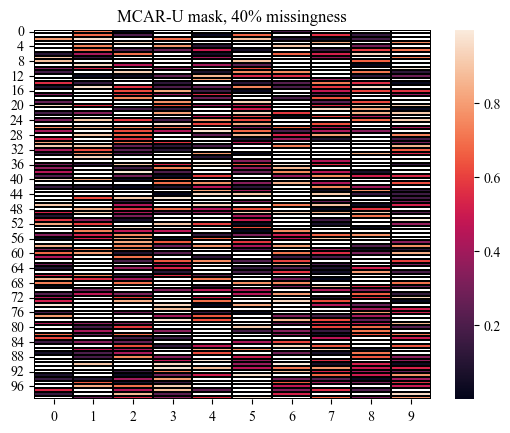

In [669]:
for i in num_tests:
    X_miss_mcar_U = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR")

    X_mcar_U = X_miss_mcar_U['X_incomp']
    R_mcar_U = X_miss_mcar_U['mask']

print("Percentage of newly generated missing values: ", (R_mcar_U.sum())/np.prod(R_mcar_U.shape)*100, " %")
ax = sns.heatmap(X_mcar_U[:100], mask=R_mcar_U[:100]==1, linewidths=0.005, linecolor='black')

pattern_name = "MCAR-U"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

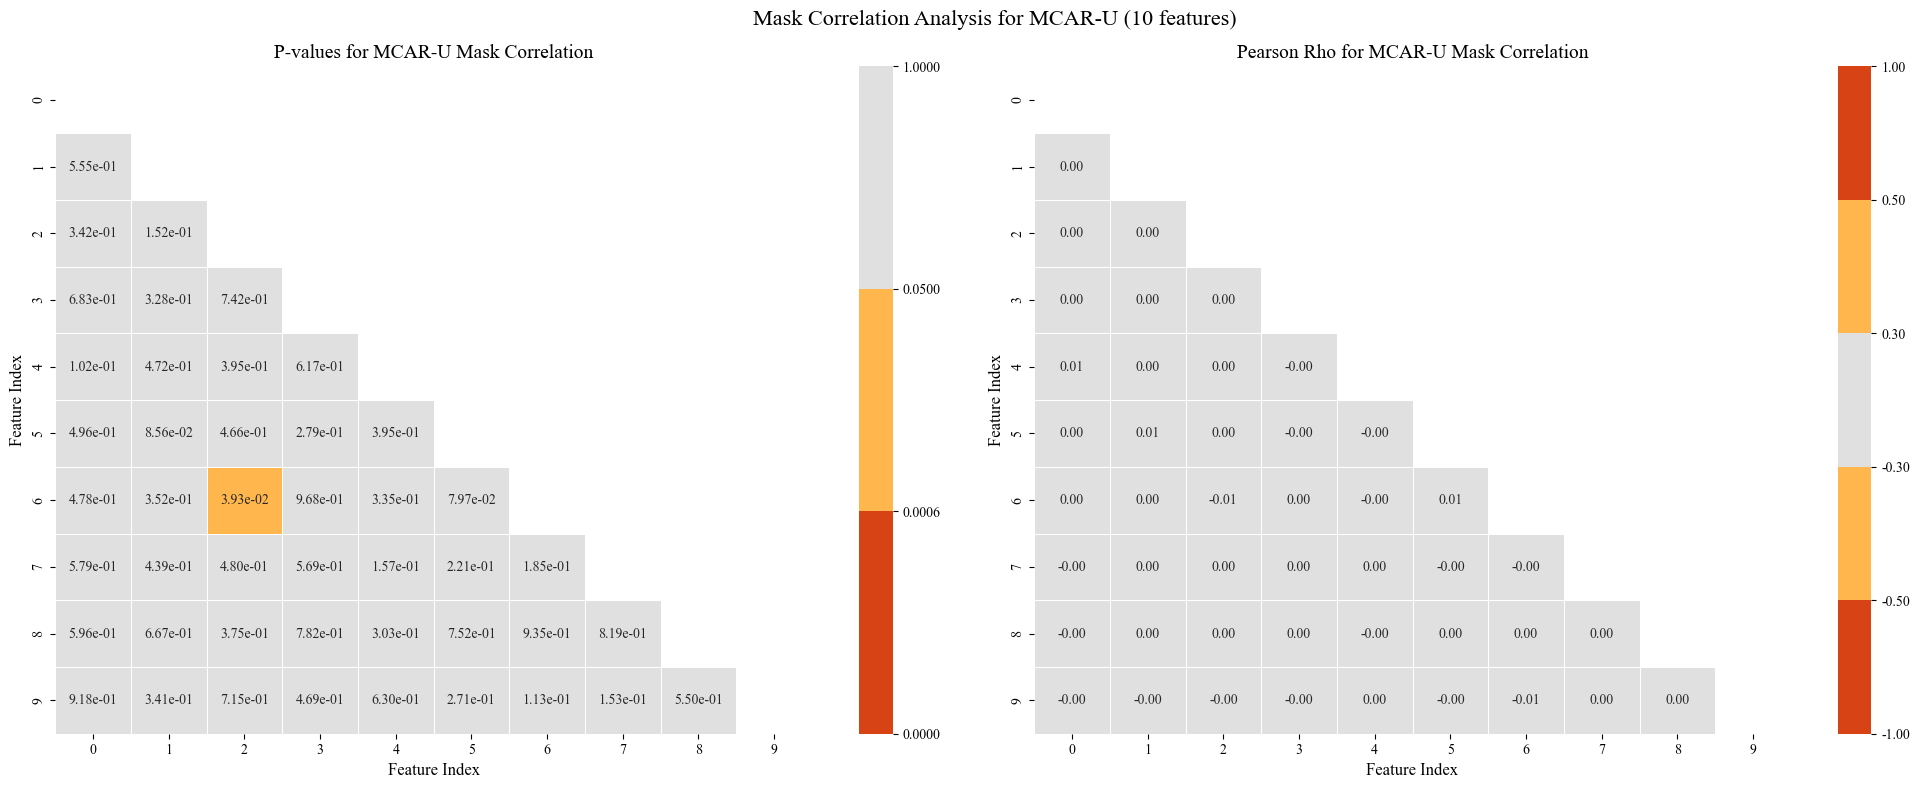

In [670]:
plot_mask_corr(R_mcar_U, "MCAR-U")

### MCAR Structured

#### MCAR WS-Block (II)

Percentage of newly generated missing values:  39.9495  %


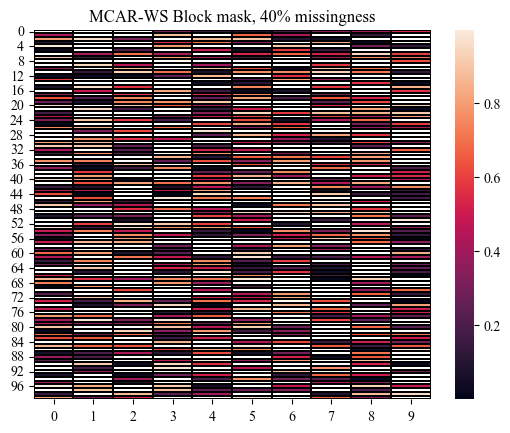

In [671]:
for i in num_tests:
    betas = iter([2, -2, 2, -2, 2, -2, 2, -2, 2, -2])
    # X_miss_mcar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=True, sequential=False,coeff_dist="betas",coeff_arg0=betas)
    X_miss_mcar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=True, sequential=False)
    X_mcar_WSB = X_miss_mcar_WSB['X_incomp']
    R_mcar_WSB = X_miss_mcar_WSB['mask']

print("Percentage of newly generated missing values: ", (R_mcar_WSB.sum())/np.prod(R_mcar_WSB.shape)*100, " %")
ax = sns.heatmap(X_mcar_WSB[:100], mask=R_mcar_WSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MCAR-WS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

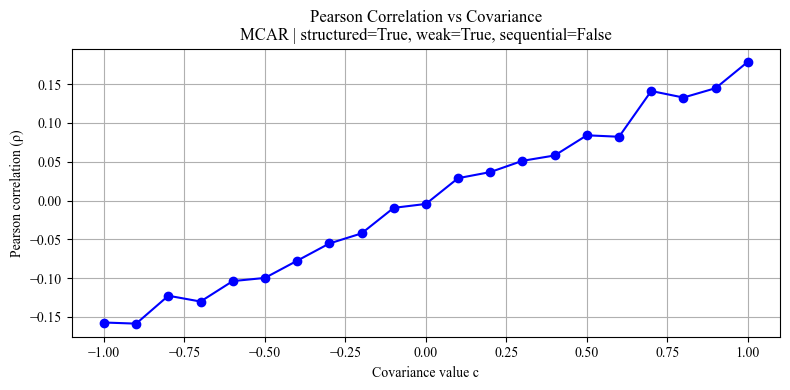

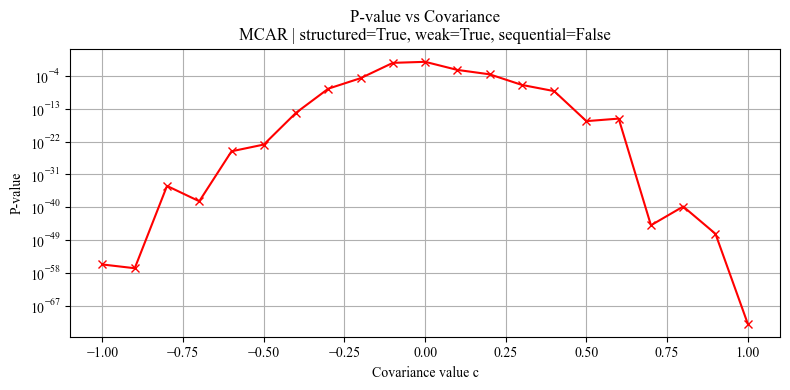

In [672]:
test_cov(mecha="MCAR", structured=True, weak=True, sequential=False)

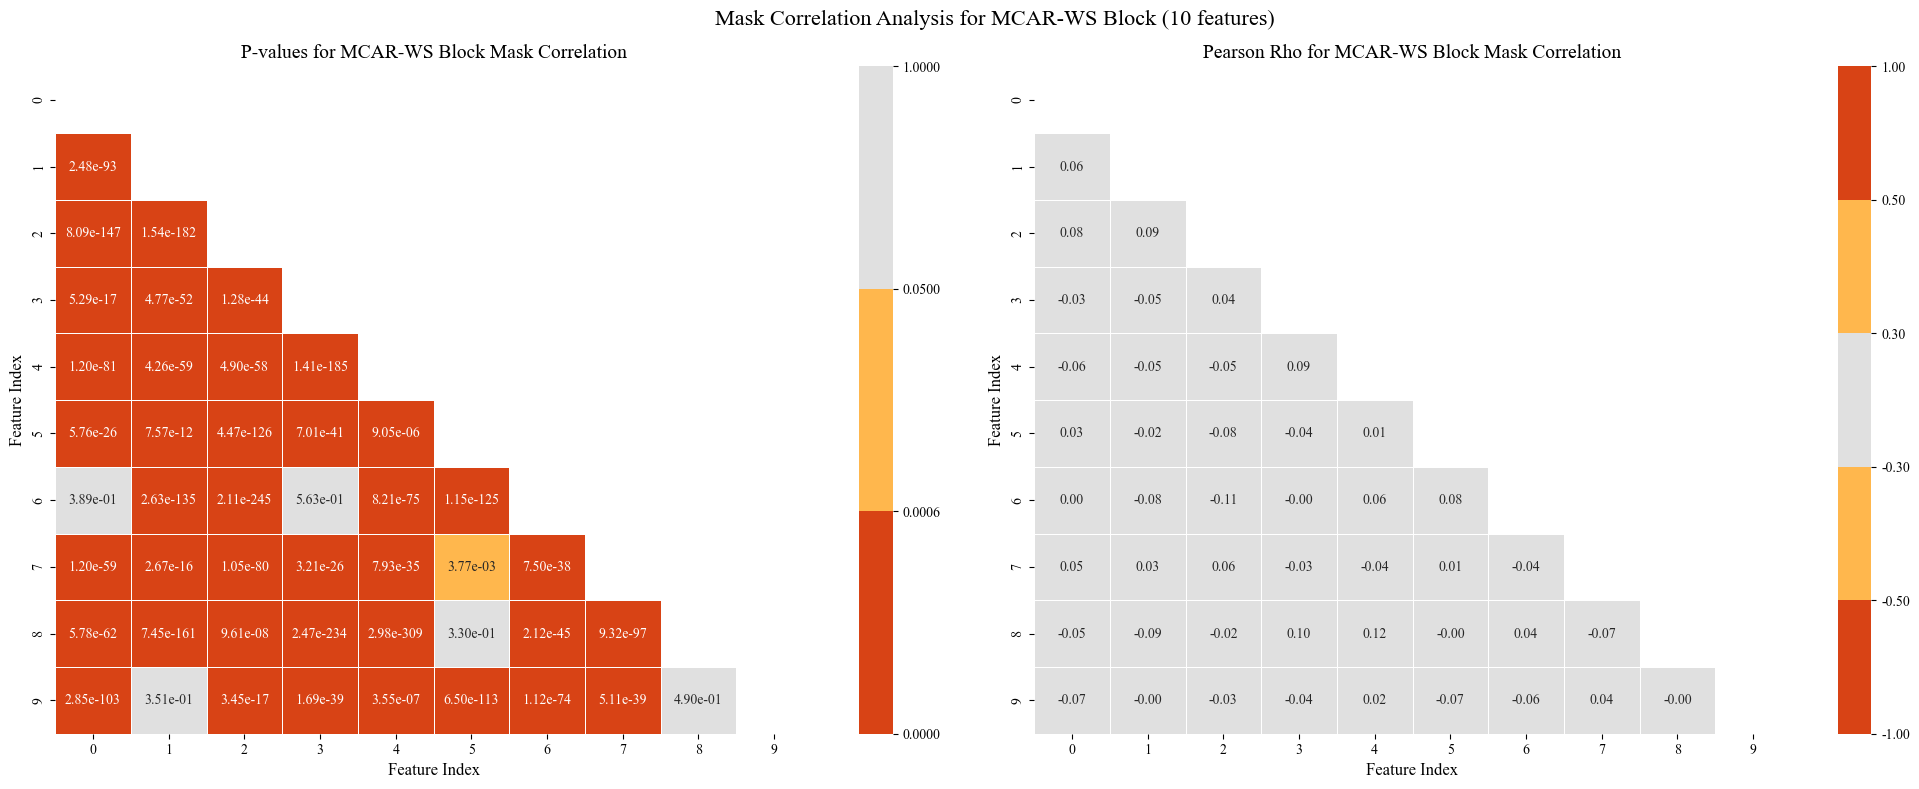

In [673]:
plot_mask_corr(R_mcar_WSB, "MCAR-WS Block")

#### MCAR SS-Block (III)

Percentage of newly generated missing values:  40.0  %


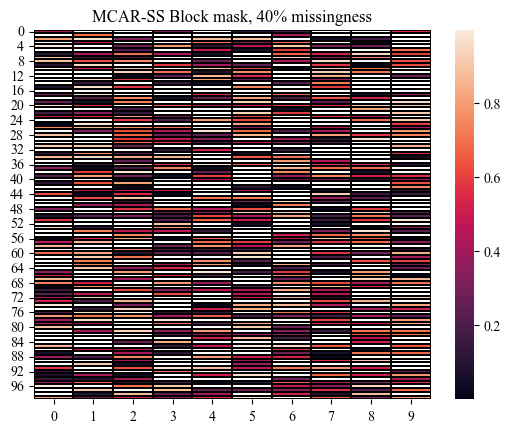

In [674]:
for i in num_tests:
    betas = iter([2, -1, -2, 2, -2, -2, 2, -2, 2, -2])
    X_miss_mcar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=False)
    # X_miss_mcar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=False,dist="betas",arg0=betas)
    
    
    X_mcar_SSB = X_miss_mcar_SSB['X_incomp']
    R_mcar_SSB = X_miss_mcar_SSB['mask']

print("Percentage of newly generated missing values: ", (R_mcar_SSB.sum())/np.prod(R_mcar_SSB.shape)*100, " %")
ax = sns.heatmap(X_mcar_SSB[:100], mask=R_mcar_SSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MCAR-SS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

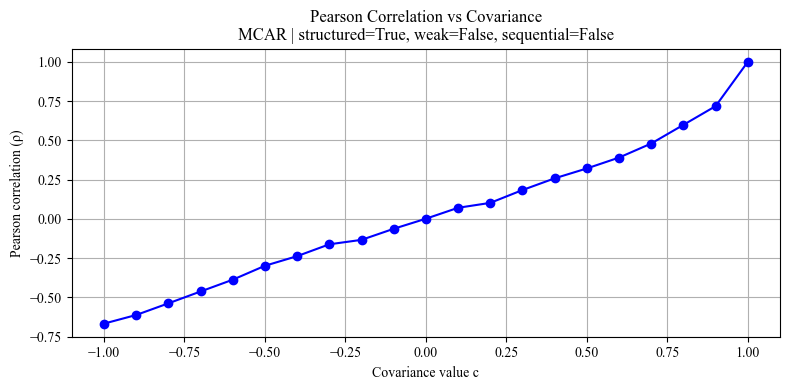

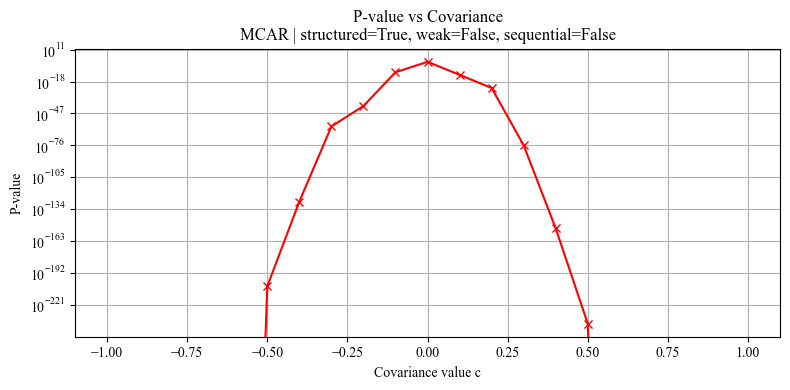

In [675]:
test_cov(mecha="MCAR", structured=True, weak=False, sequential=False)

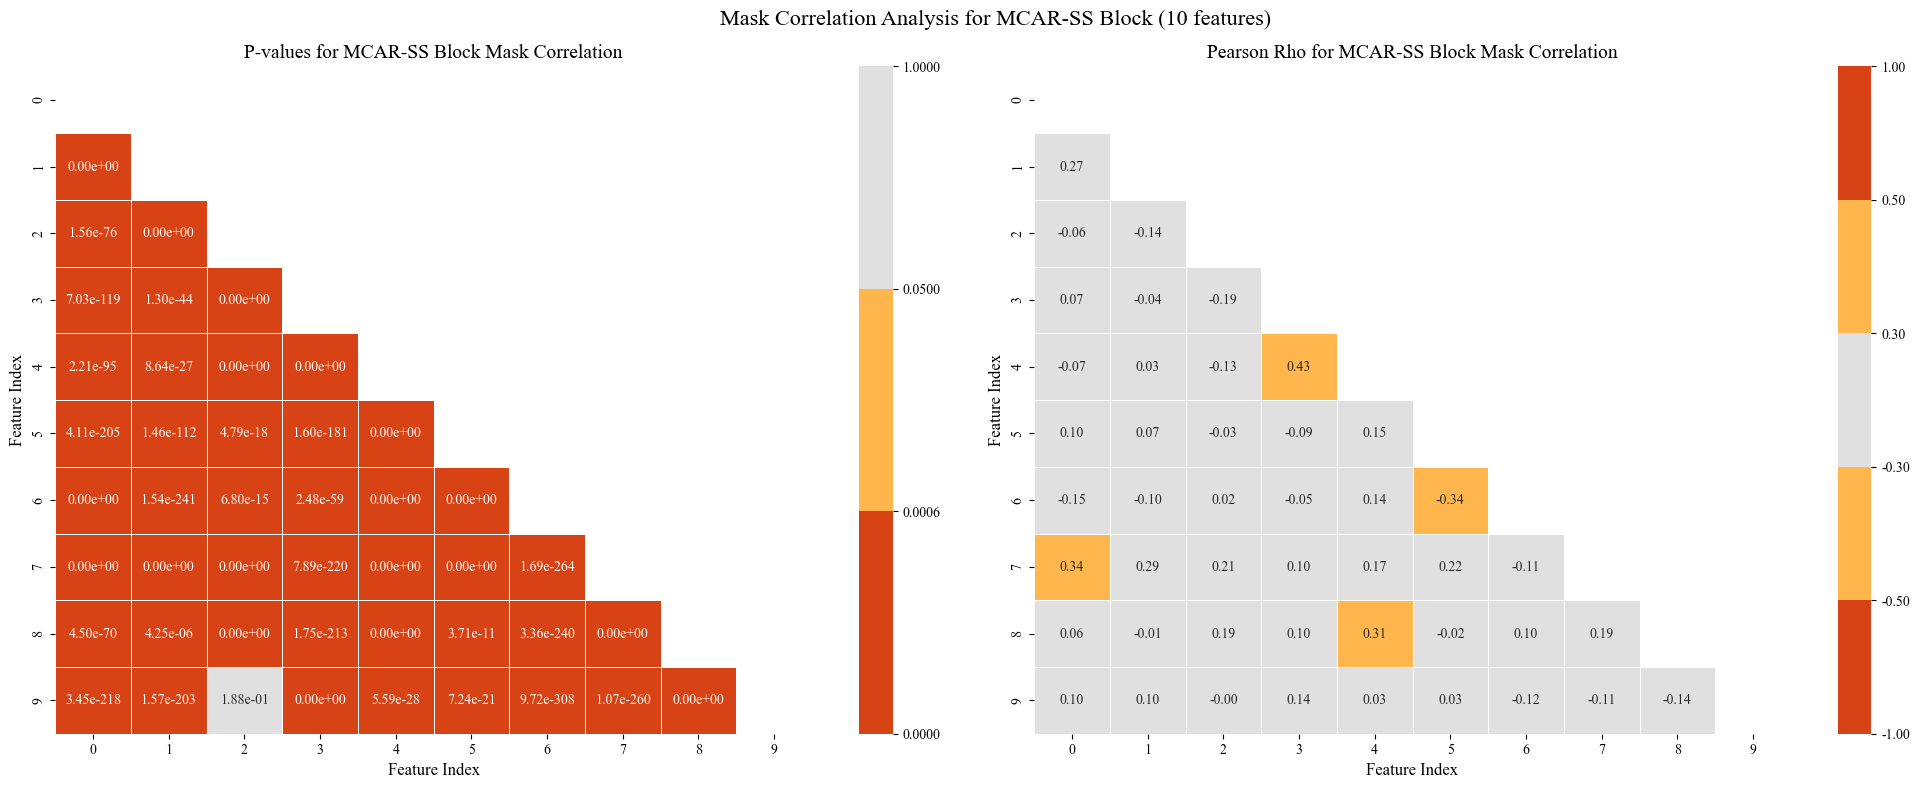

In [676]:
plot_mask_corr(R_mcar_SSB, "MCAR-SS Block")

#### MCAR WS-Sequential (IV)

Percentage of newly generated missing values:  40.0394  %


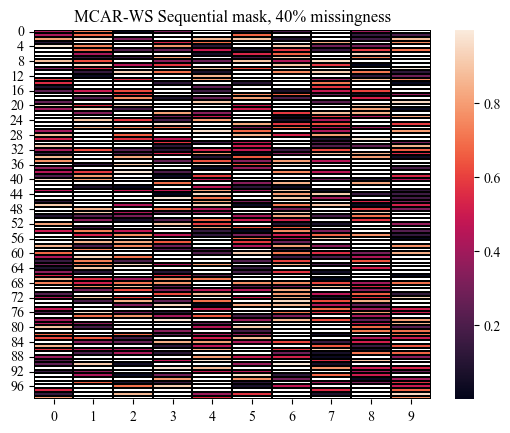

In [677]:
for i in num_tests:
    X_miss_mcar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=True, sequential=True)

    X_mcar_WSS = X_miss_mcar_WSS['X_incomp']
    R_mcar_WSS = X_miss_mcar_WSS['mask']

print("Percentage of newly generated missing values: ", (R_mcar_WSS.sum())/np.prod(R_mcar_WSS.shape)*100, " %")
ax = sns.heatmap(X_mcar_WSS[:100], mask=R_mcar_WSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MCAR-WS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

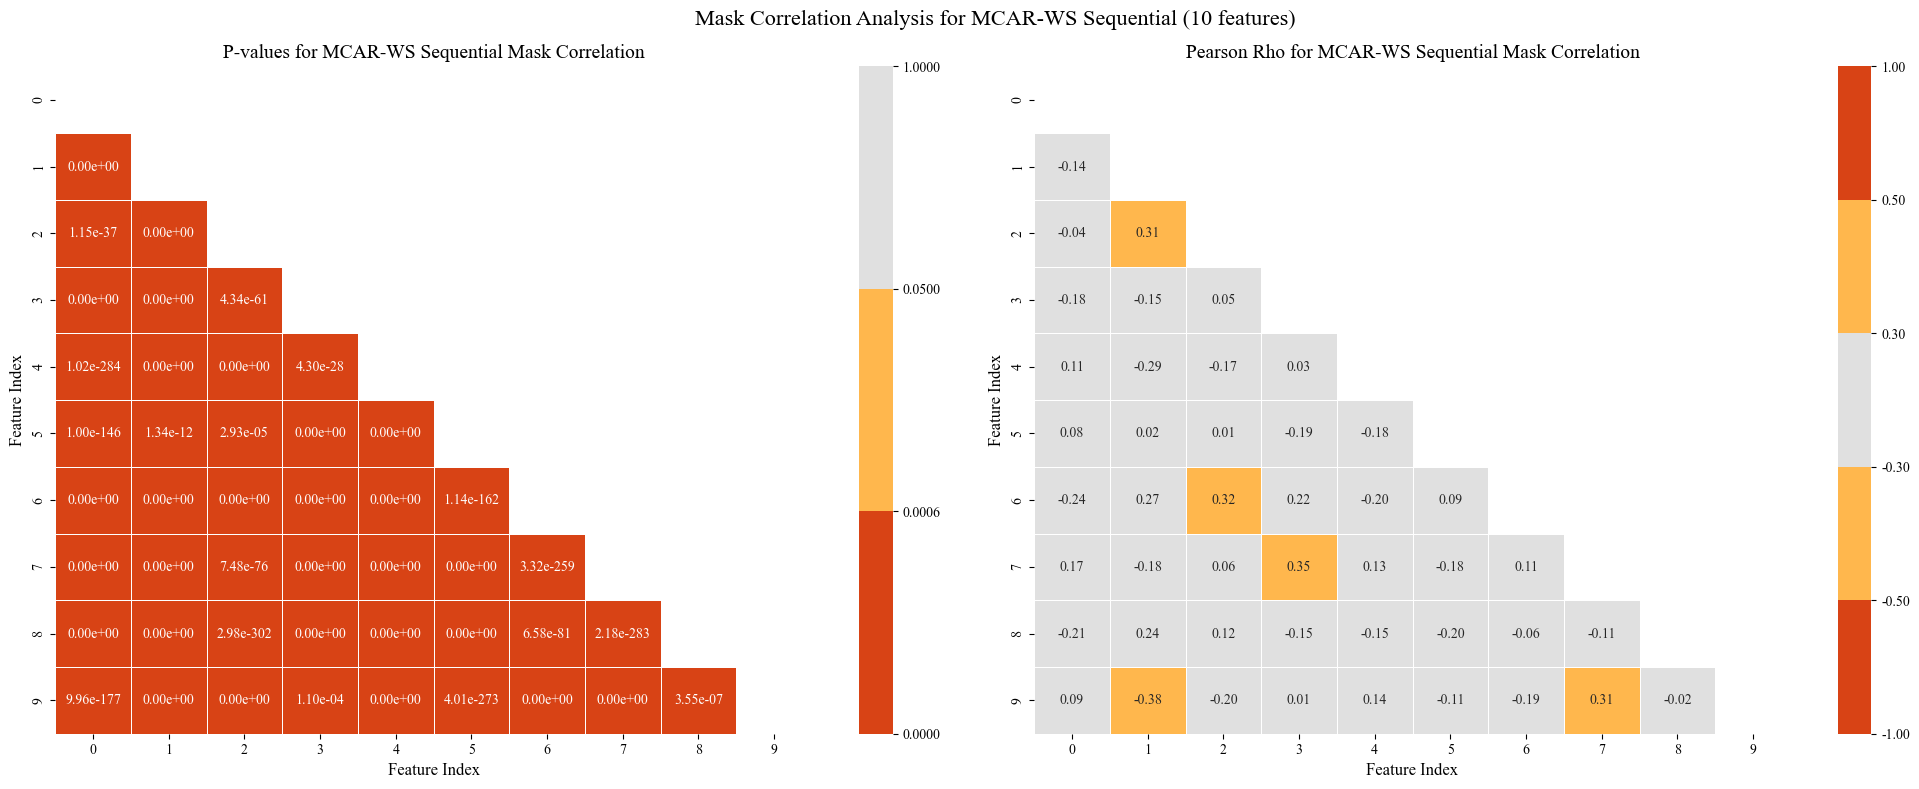

In [678]:
plot_mask_corr(R_mcar_WSS, "MCAR-WS Sequential")

#### MCAR SS-Sequential (V)

Percentage of newly generated missing values:  47.9686  %


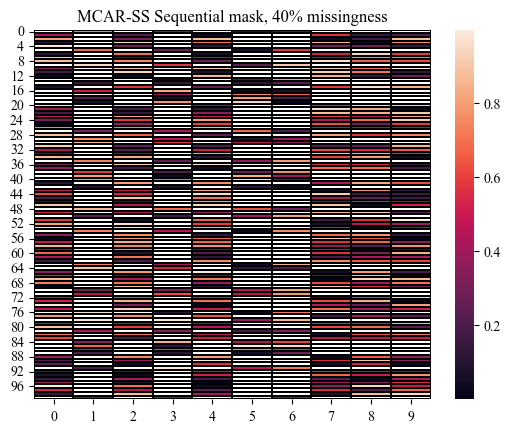

In [679]:
j = 0
for i in num_tests:
    betas = iter([2, -2, -2, 2, -2, -2, 2, -2, 2, -2])
    X_miss_mcar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MCAR", structured=True, weak=False, sequential=True)

    X_mcar_SSS = X_miss_mcar_SSS['X_incomp']
    R_mcar_SSS = X_miss_mcar_SSS['mask']

#print(j/len(num_tests))
print("Percentage of newly generated missing values: ", (R_mcar_SSS.sum())/np.prod(R_mcar_SSS.shape)*100, " %")
ax = sns.heatmap(X_mcar_SSS[:100], mask=R_mcar_SSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MCAR-SS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

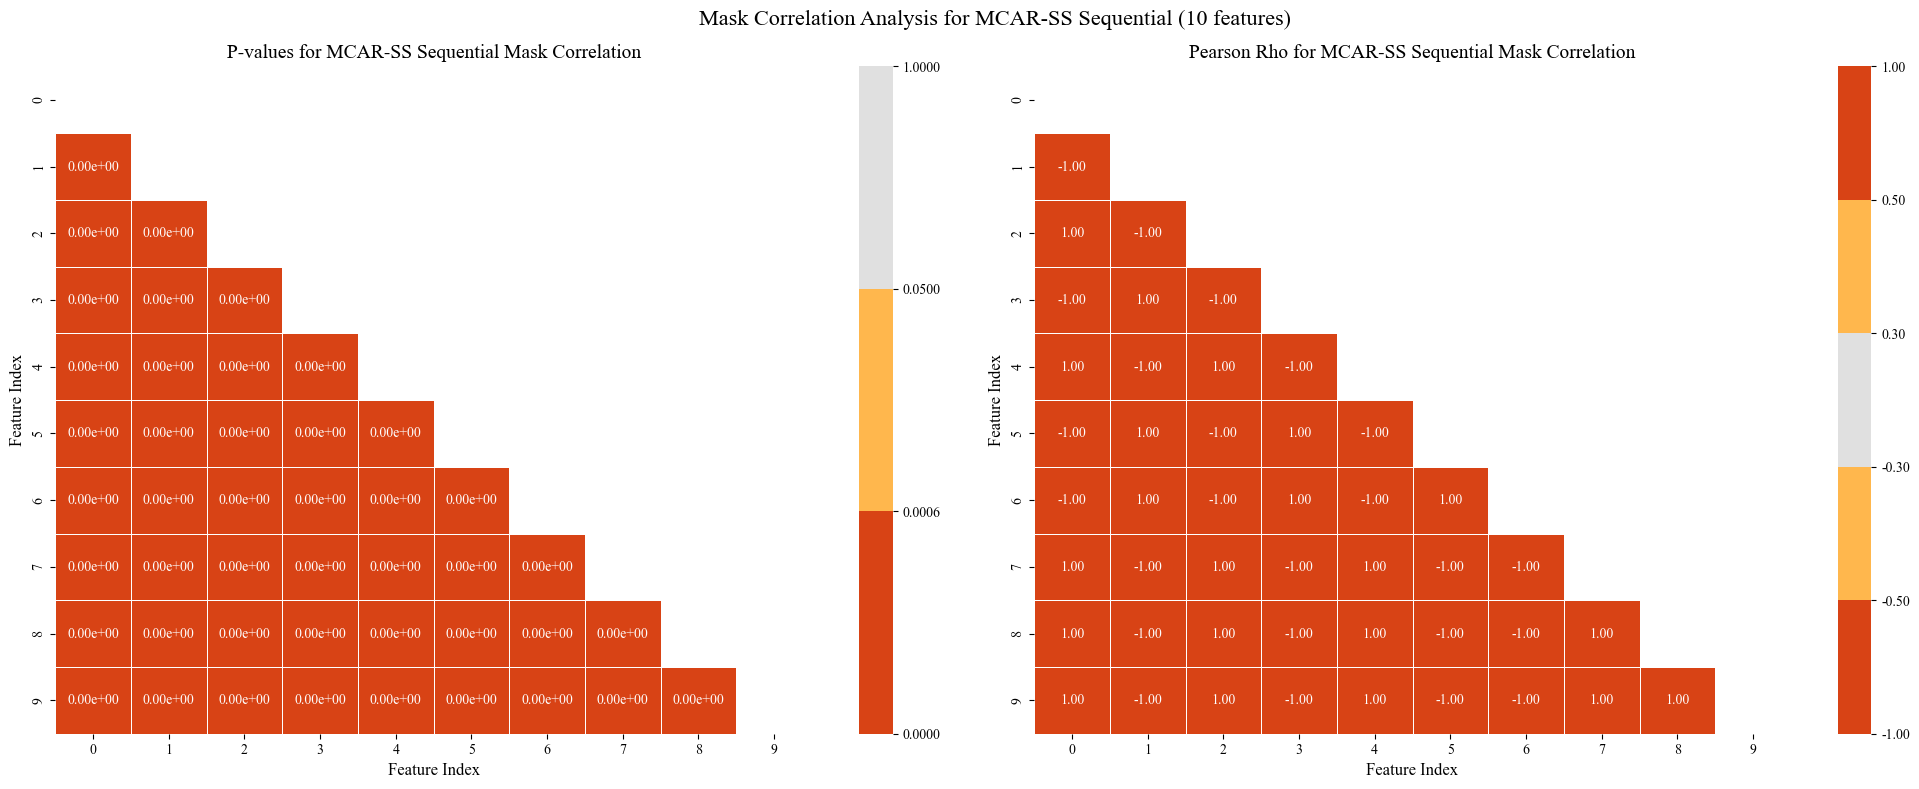

In [680]:
plot_mask_corr(R_mcar_SSS, "MCAR-SS Sequential")

# MAR

### MAR Unstructured

#### MAR Unstructured-Prob. (VI)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  19.9965  %


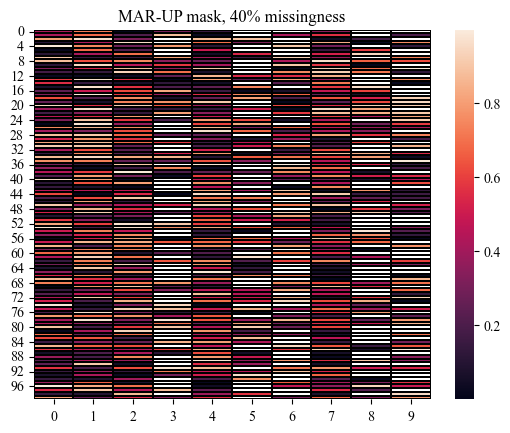

In [681]:
for i in num_tests:
    X_miss_mar_UP = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", weak=True, p_obs=0.5)
    X_mar_UP = X_miss_mar_UP['X_incomp']
    R_mar_UP = X_miss_mar_UP['mask']

print("Percentage of generated missing values: ", (R_mar_UP.sum())/np.prod(R_mar_UP.shape)*100, " %")

ax = sns.heatmap(X_mar_UP[:100], mask=R_mar_UP[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-UP"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

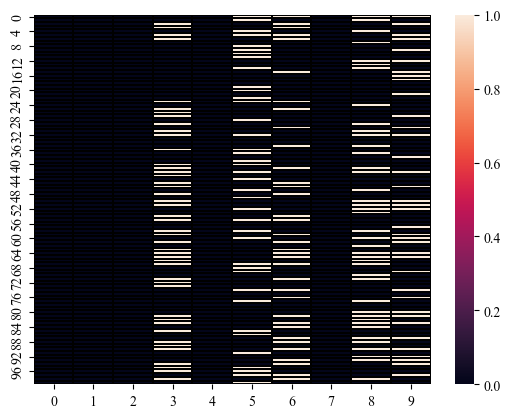

In [682]:
ax = sns.heatmap(R_mar_UP[:100], linewidths=0.005, linecolor='black')

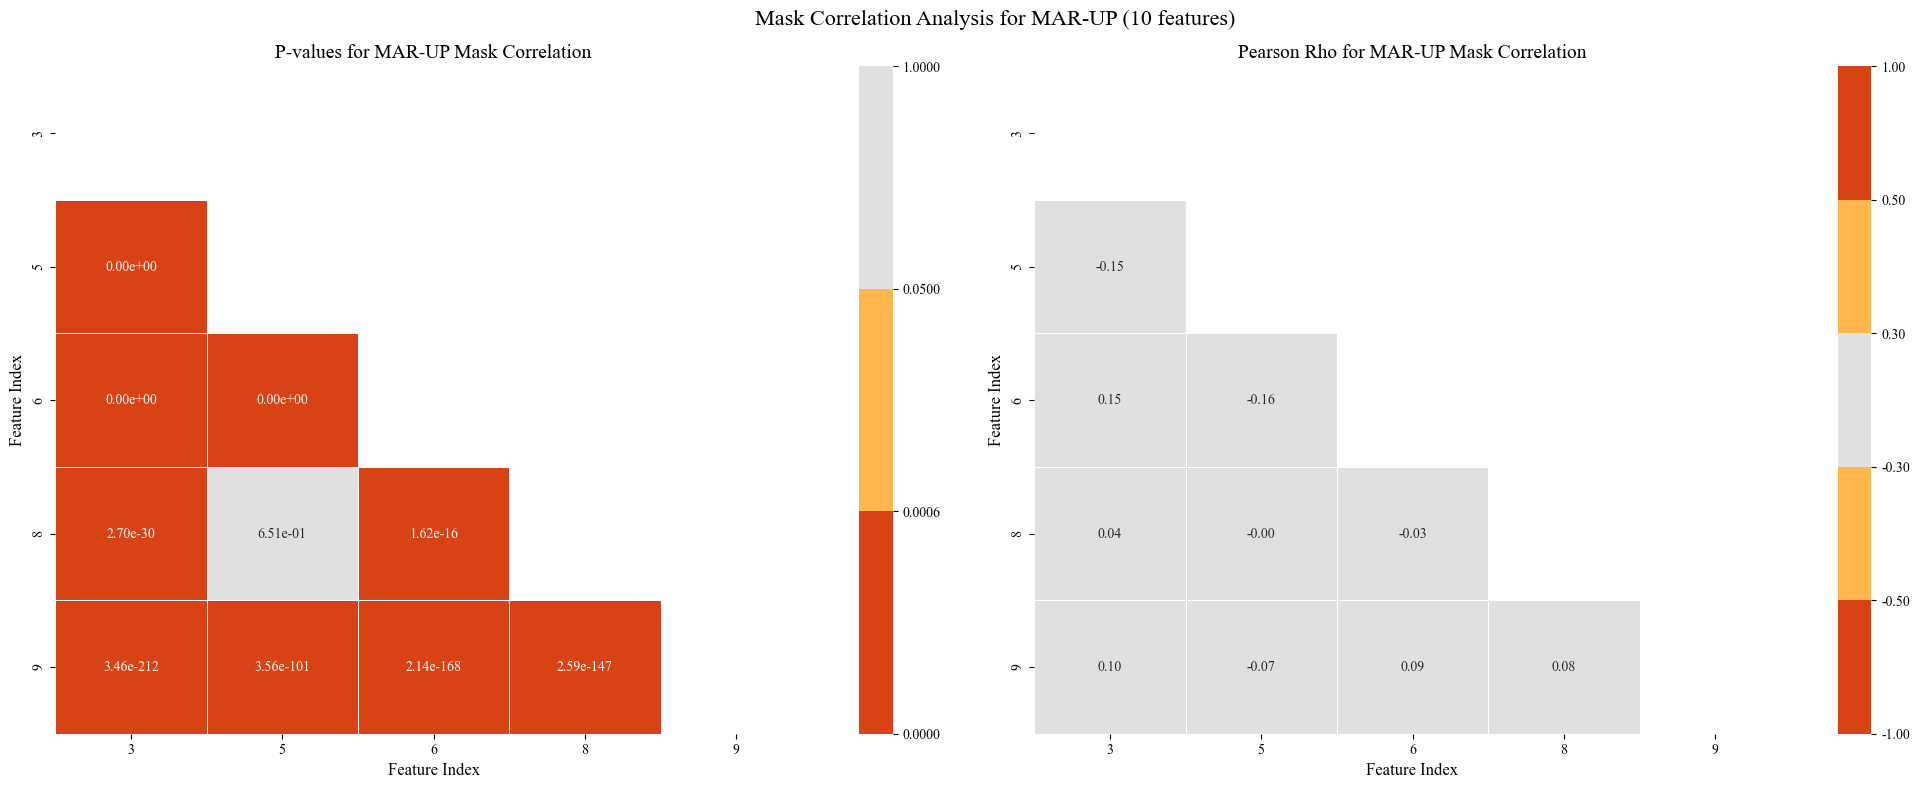

In [683]:
plot_mask_corr(R_mar_UP, "MAR-UP")

#### MAR Unstructured-Det. (VII)

Percentage of generated missing values:  20.0  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


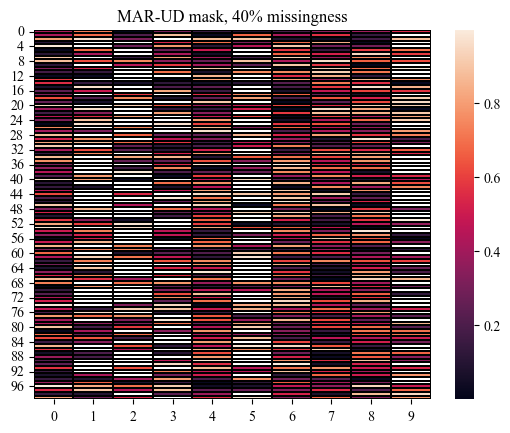

In [684]:
for i in num_tests:
    X_miss_mar_UD = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", weak=False, p_obs=0.5)

    X_mar_UD = X_miss_mar_UD['X_incomp']
    R_mar_UD = X_miss_mar_UD['mask']

print("Percentage of generated missing values: ", (R_mar_UD.sum())/np.prod(R_mar_UD.shape)*100, " %")

ax = sns.heatmap(X_mar_UD[:100], mask=R_mar_UD[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-UD"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

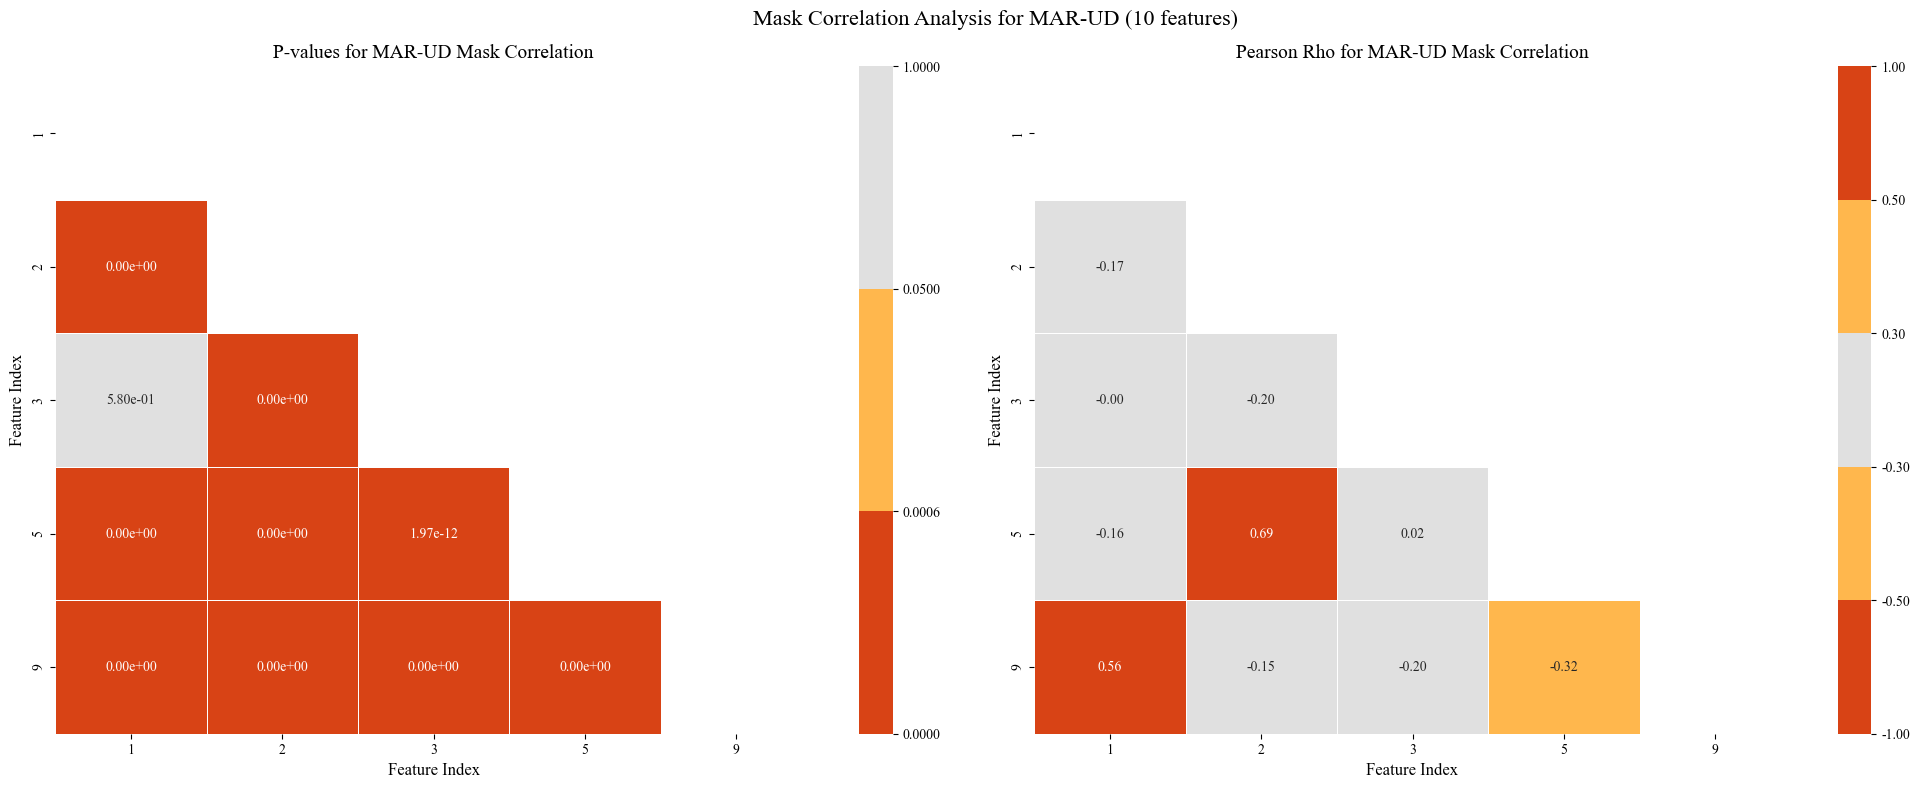

In [685]:
plot_mask_corr(R_mar_UD, "MAR-UD")

### MAR Structured

#### MAR WS-Block (VIII)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  20.0164  %


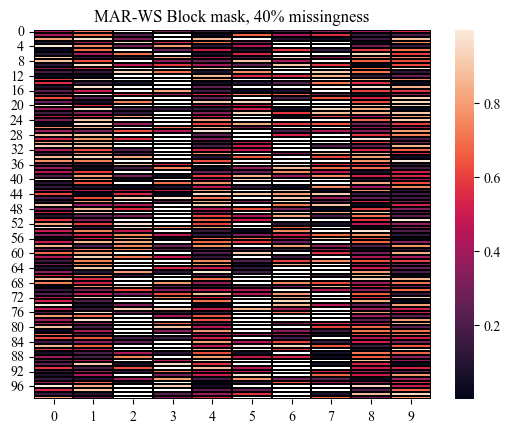

In [686]:
for i in num_tests:
    X_miss_mar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=True, sequential=False, coeff_dist="normal", coeff_arg0=1, coeff_arg1=0)

    X_mar_WSB = X_miss_mar_WSB['X_incomp']
    R_mar_WSB = X_miss_mar_WSB['mask']

print("Percentage of generated missing values: ", (R_mar_WSB.sum())/np.prod(R_mar_WSB.shape)*100, " %")

ax = sns.heatmap(X_mar_WSB[:100], mask=R_mar_WSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-WS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


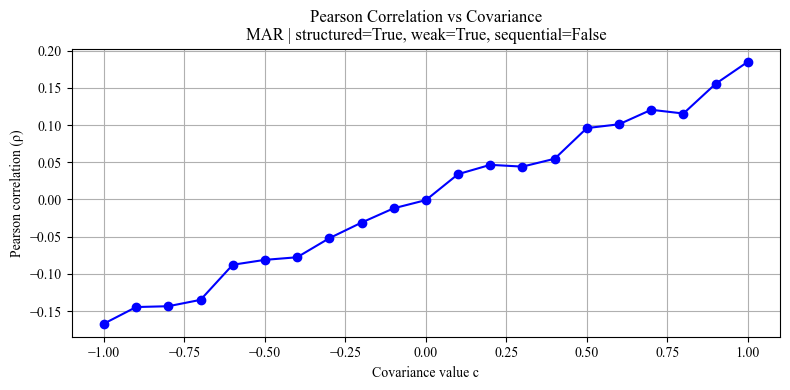

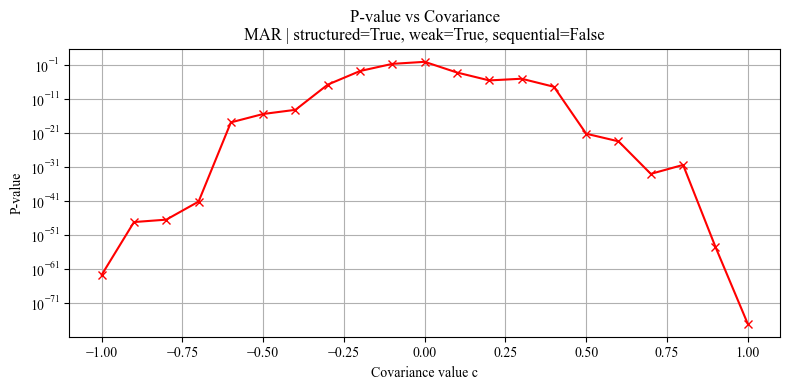

In [687]:
test_cov(mecha="MAR", structured=True, weak=True, sequential=False)

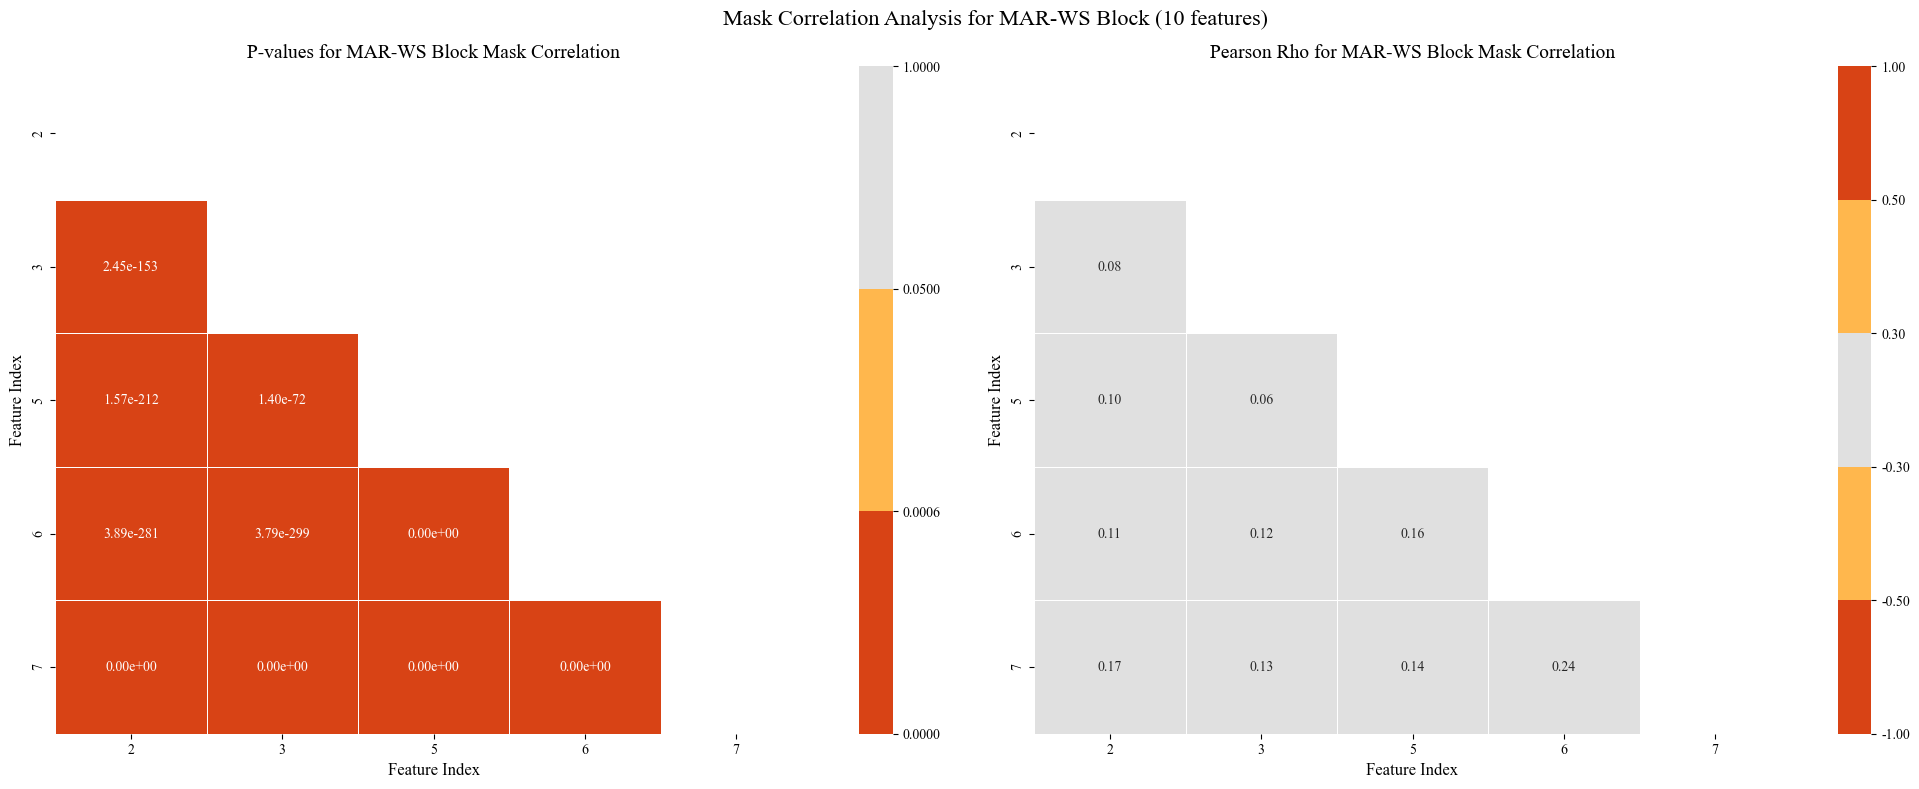

In [688]:
plot_mask_corr(R_mar_WSB, "MAR-WS Block")

#### MAR SS-Block (IX)

Percentage of generated missing values:  20.0  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


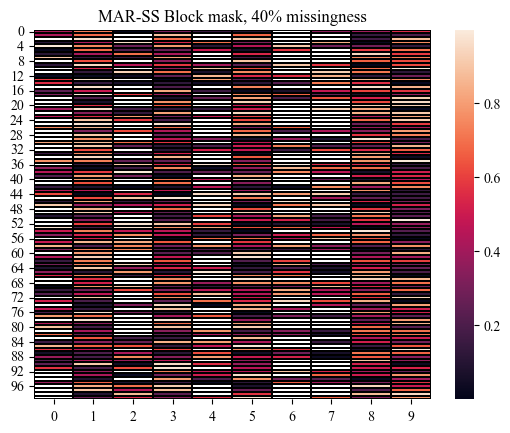

In [689]:
for i in num_tests:
    X_miss_mar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=False, sequential=False, coeff_dist="normal", coeff_arg0=1, coeff_arg1=0)

    X_mar_SSB = X_miss_mar_SSB['X_incomp']
    R_mar_SSB = X_miss_mar_SSB['mask']

print("Percentage of generated missing values: ", (R_mar_SSB.sum())/np.prod(R_mar_SSB.shape)*100, " %")

ax = sns.heatmap(X_mar_SSB[:100], mask=R_mar_SSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-SS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


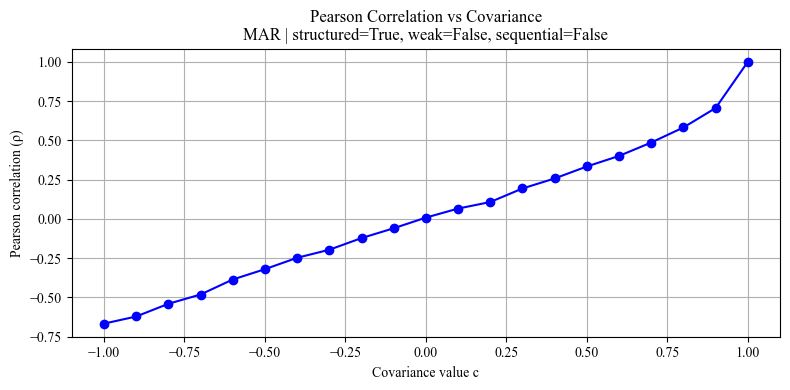

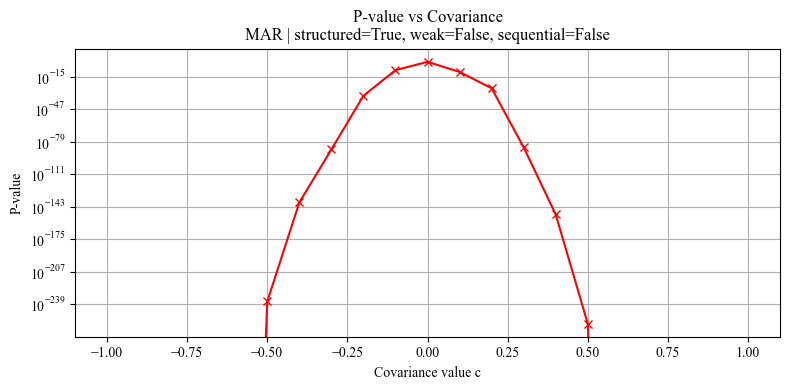

In [690]:
test_cov(mecha="MAR", structured=True, weak=False, sequential=False)

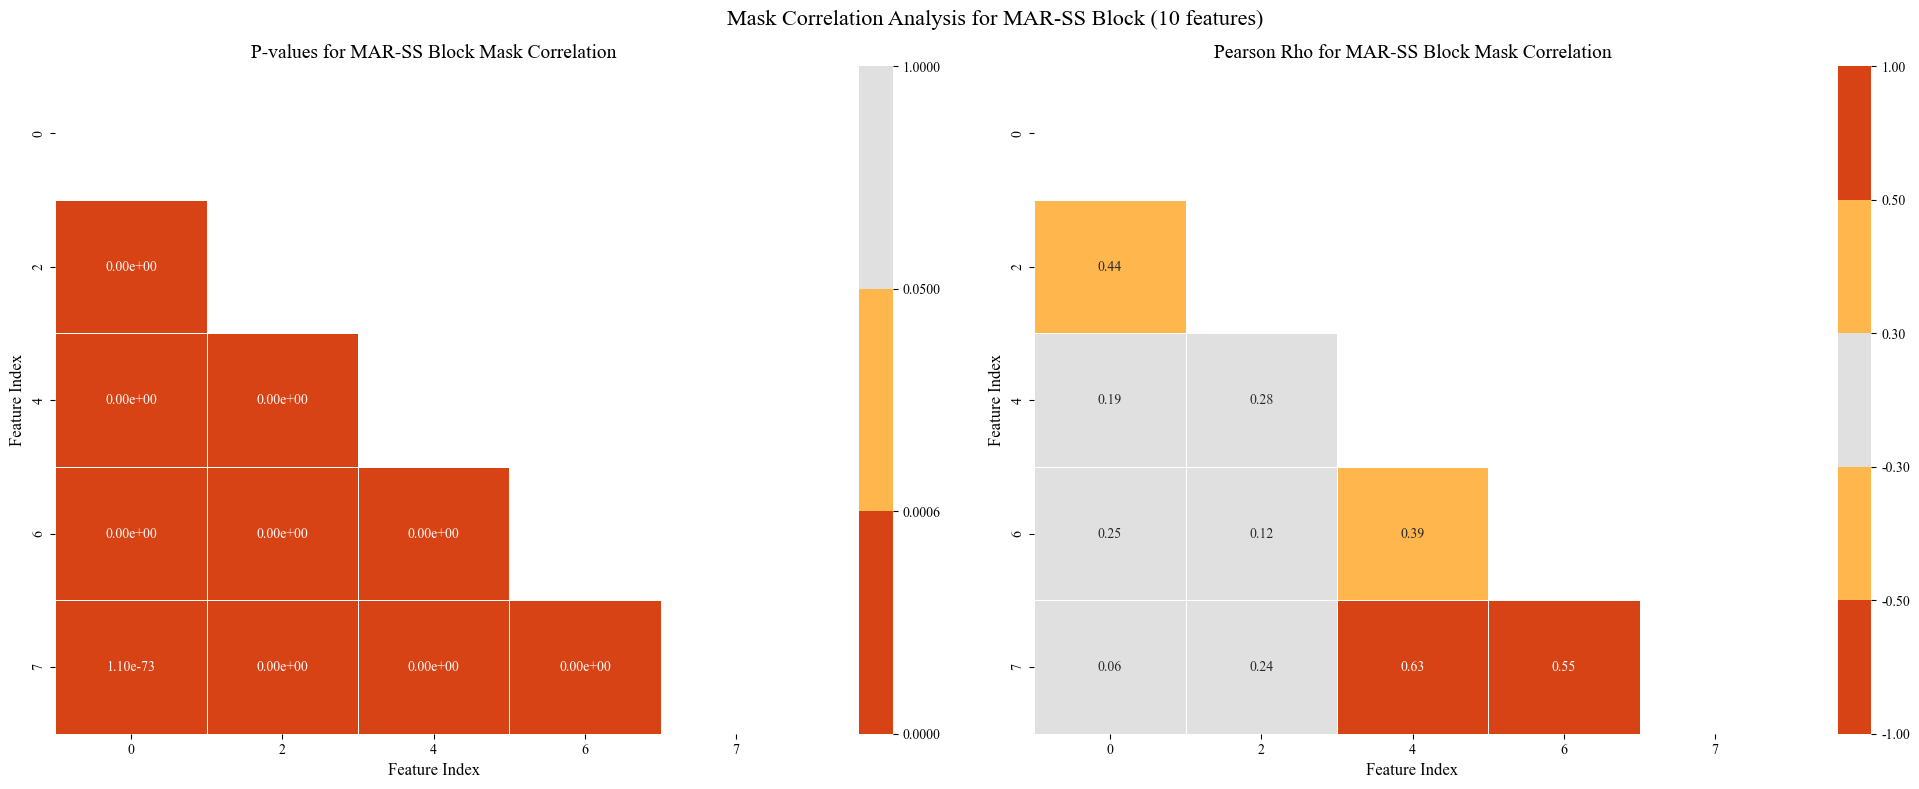

In [691]:
plot_mask_corr(R_mar_SSB, "MAR-SS Block")

#### MAR WS-Sequential (X)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  19.9071  %


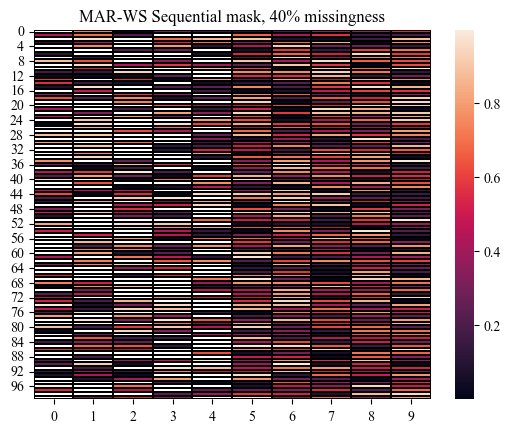

In [692]:
import warnings
# warnings.filterwarnings('ignore')

for i in num_tests:
    X_miss_mar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=True, sequential=True)

    X_mar_WSS = X_miss_mar_WSS['X_incomp']
    R_mar_WSS = X_miss_mar_WSS['mask']

print("Percentage of generated missing values: ", (R_mar_WSS.sum())/np.prod(R_mar_WSS.shape)*100, " %")

ax = sns.heatmap(X_mar_WSS[:100], mask=R_mar_WSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-WS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

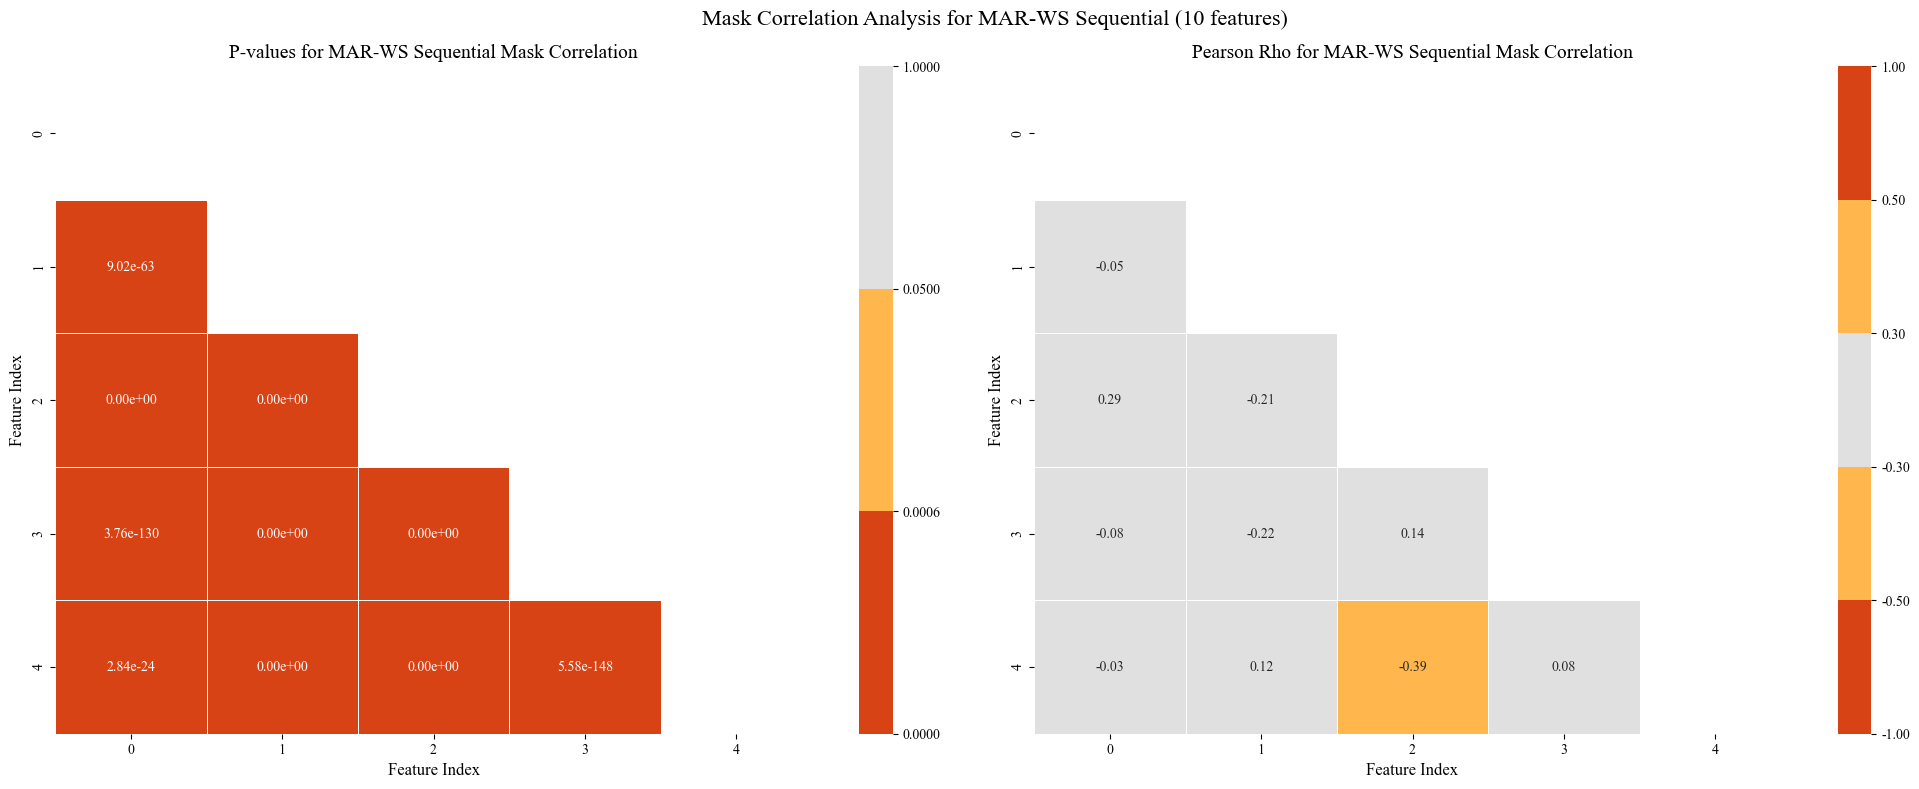

In [693]:
plot_mask_corr(R_mar_WSS, "MAR-WS Sequential")

#### MAR SS-Sequential (XI)

Percentage of generated missing values:  20.0  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


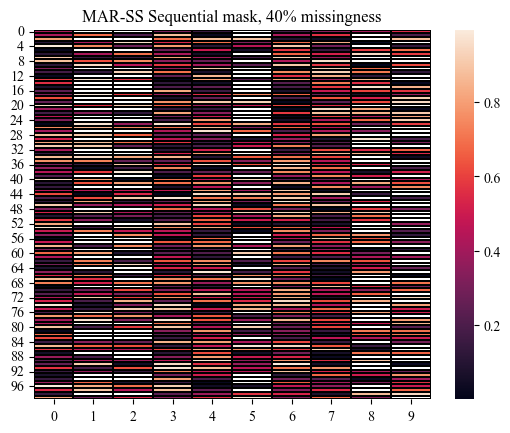

In [694]:
for i in num_tests:
    X_miss_mar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MAR", p_obs=0.5, structured=True, weak=False, sequential=True)

    X_mar_SSS = X_miss_mar_SSS['X_incomp']
    R_mar_SSS = X_miss_mar_SSS['mask']

print("Percentage of generated missing values: ", (R_mar_SSS.sum())/np.prod(R_mar_SSS.shape)*100, " %")

ax = sns.heatmap(X_mar_SSS[:100], mask=R_mar_SSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MAR-SS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

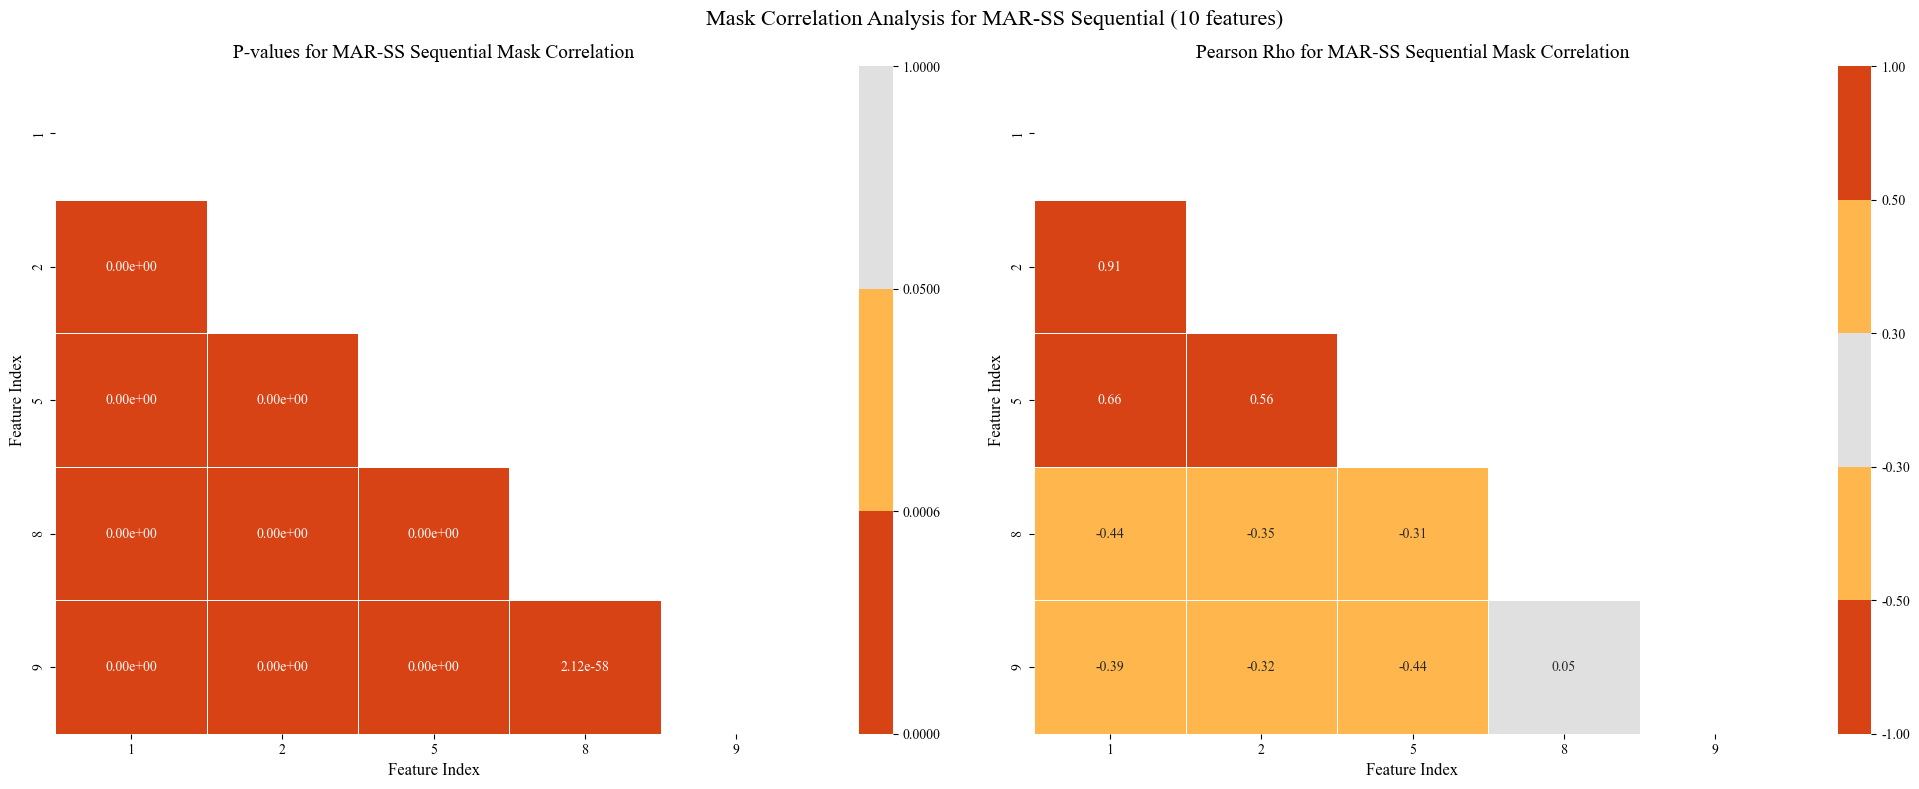

In [695]:
plot_mask_corr(R_mar_SSS, "MAR-SS Sequential")

# MNAR

### MNAR Unstructured

#### MNAR Unstructured-Prob. (XII)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  40.0136  %


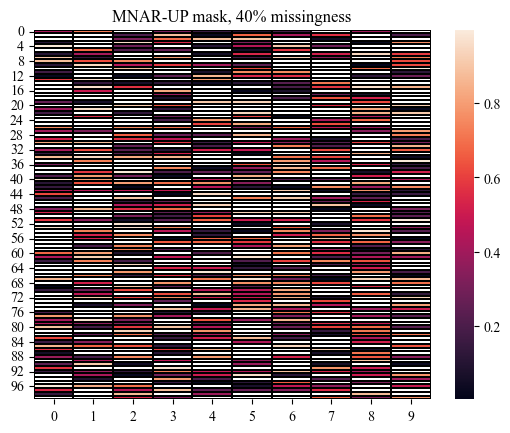

In [696]:
for i in num_tests:
    X_miss_mnar_UP = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=False, weak=True, sequential=True,idxs_obs=[0,1,2,3,4])

    X_mnar_UP = X_miss_mnar_UP['X_incomp']
    R_mnar_UP = X_miss_mnar_UP['mask']

print("Percentage of generated missing values: ", (R_mnar_UP.sum())/np.prod(R_mnar_UP.shape)*100, " %")

ax = sns.heatmap(X_mnar_UP[:100], mask=R_mnar_UP[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-UP"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

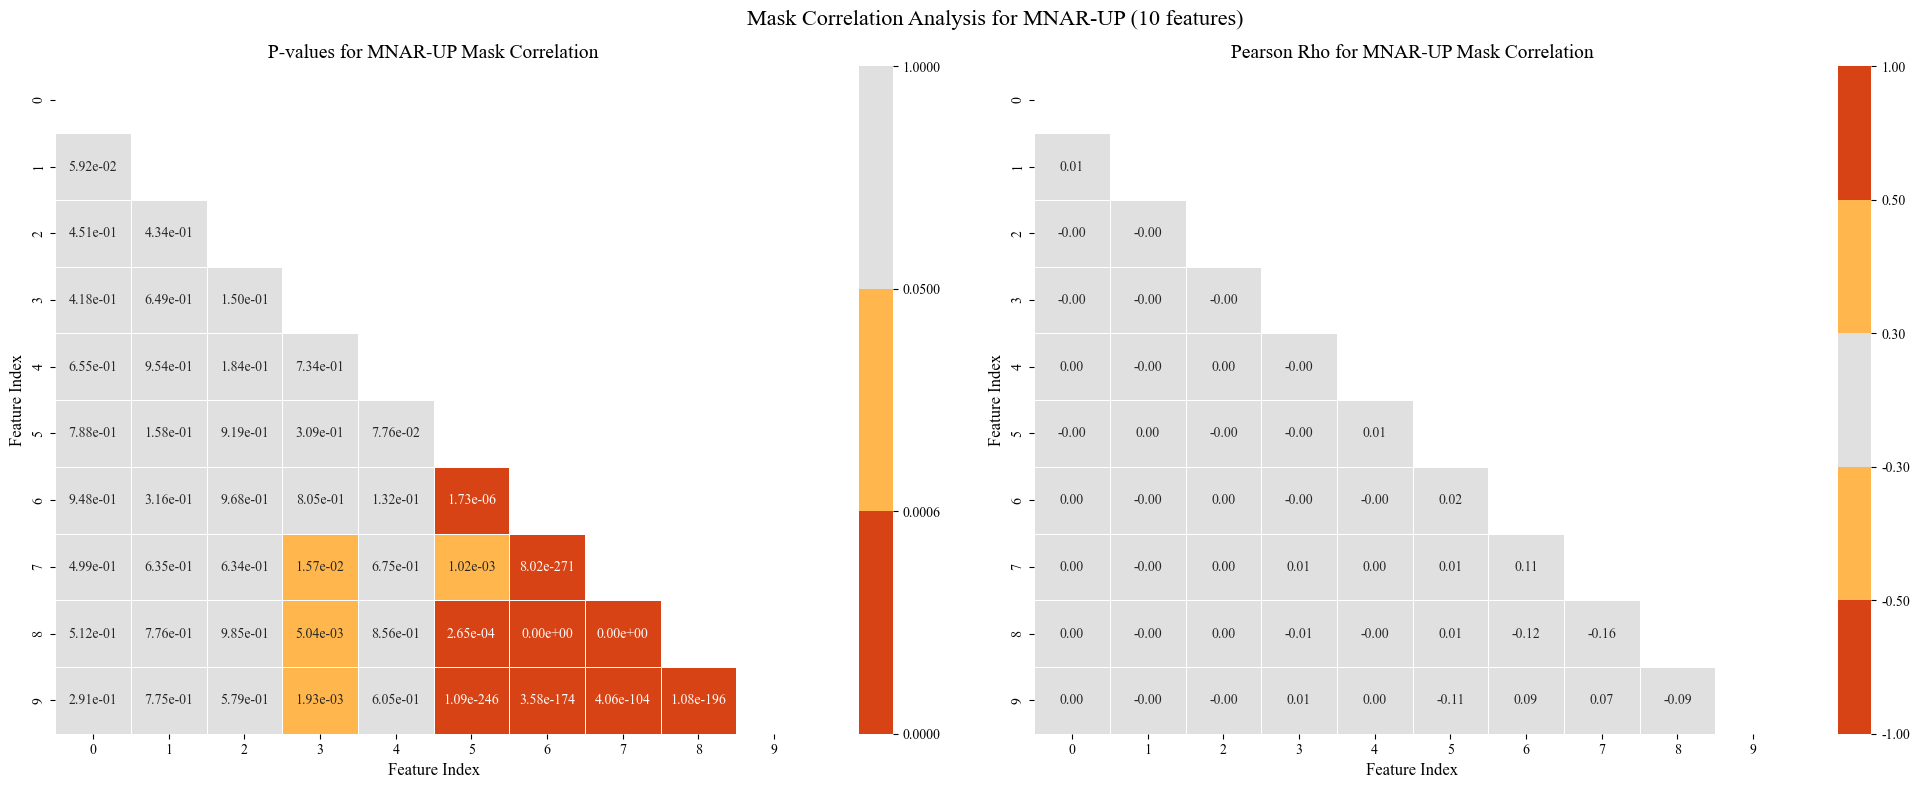

In [697]:
plot_mask_corr(R_mnar_UP, "MNAR-UP")

#### MNAR Unstructured-Det. (XIII)

Percentage of generated missing values:  40.023199999999996  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


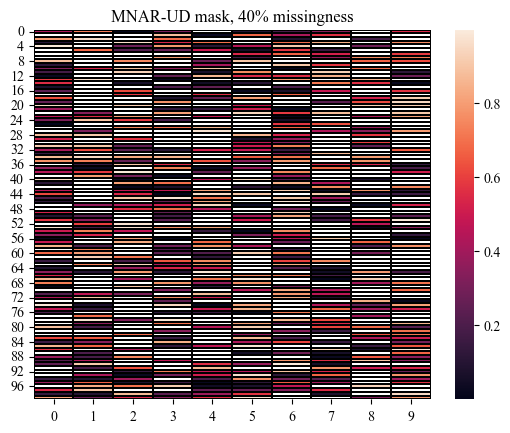

In [698]:
for i in num_tests:
    X_miss_mnar_UD = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=False, weak=False, sequential=True,idxs_obs=[0,1,2,3,4])

    X_mnar_UD = X_miss_mnar_UD['X_incomp']
    R_mnar_UD = X_miss_mnar_UD['mask']

print("Percentage of generated missing values: ", (R_mnar_UD.sum())/np.prod(R_mnar_UD.shape)*100, " %")

ax = sns.heatmap(X_mnar_UD[:100], mask=R_mnar_UD[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-UD"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

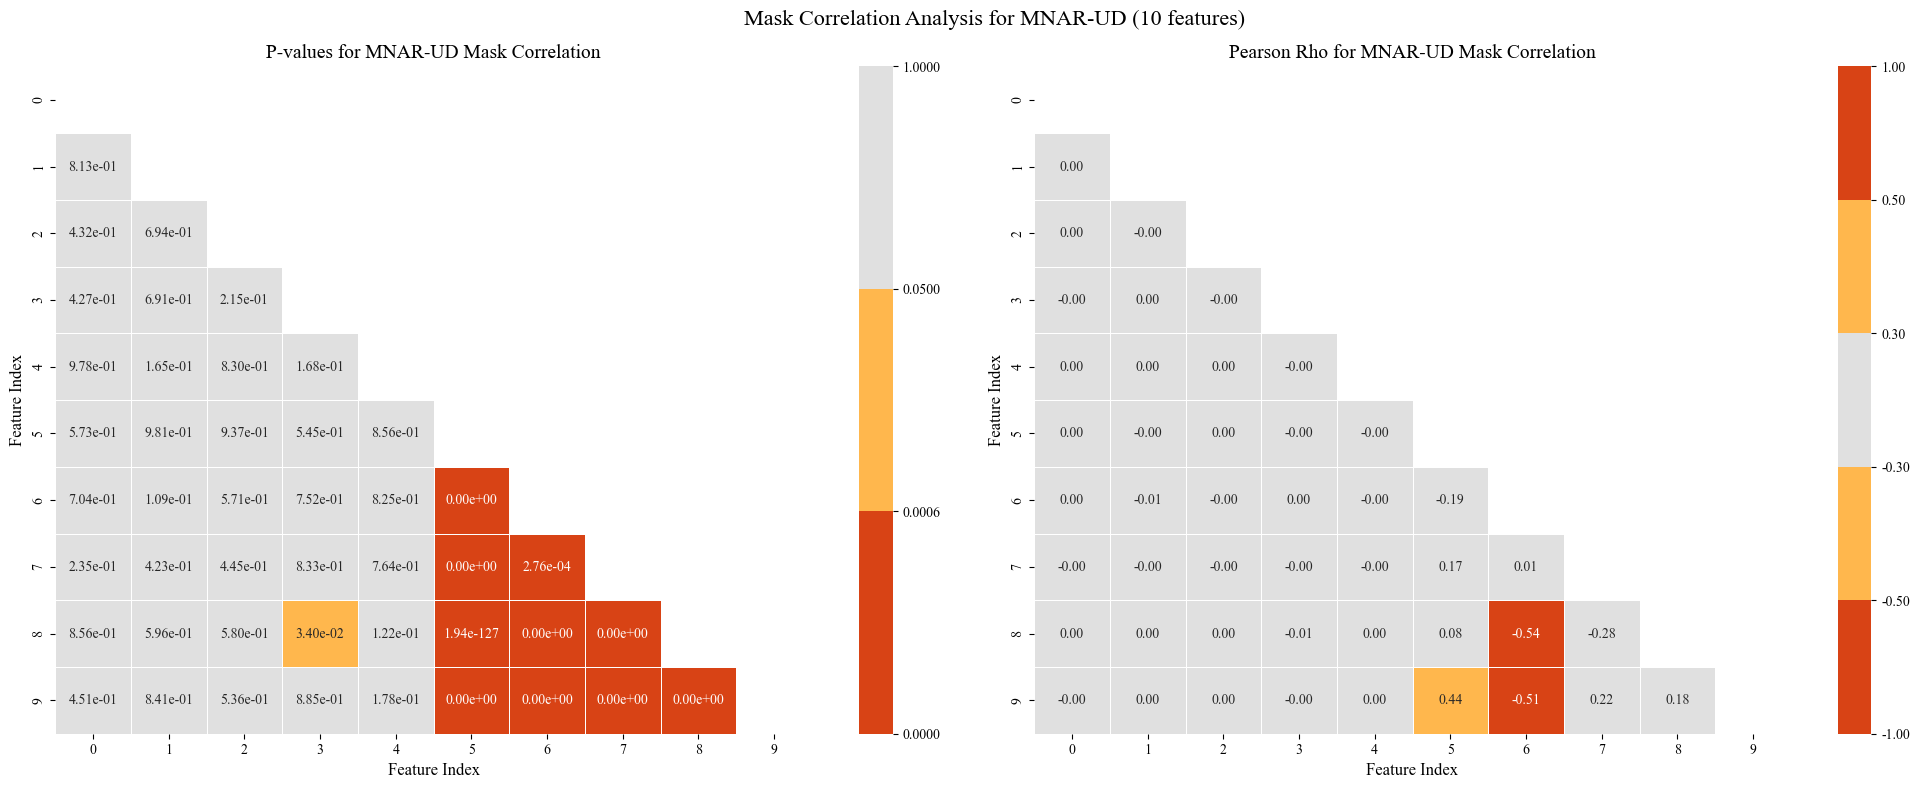

In [699]:
plot_mask_corr(R_mnar_UD, "MNAR-UD")

### MNAR Structured

#### MNAR WS-Block (XIV)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  39.938  %


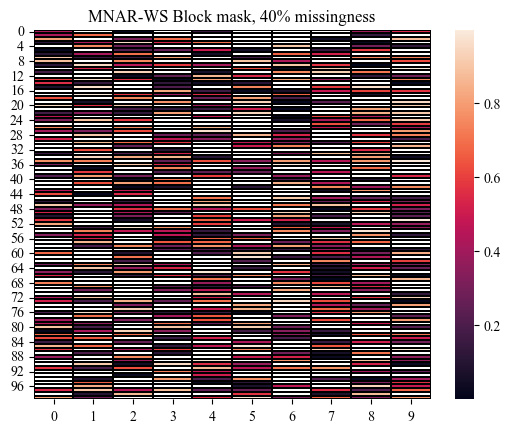

In [700]:
for i in num_tests:
    X_miss_mnar_WSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=True, sequential=False,idxs_obs=[0,1,2,3,4])

    X_mnar_WSB = X_miss_mnar_WSB['X_incomp']
    R_mnar_WSB = X_miss_mnar_WSB['mask']

print("Percentage of generated missing values: ", (R_mnar_WSB.sum())/np.prod(R_mnar_WSB.shape)*100, " %")

ax = sns.heatmap(X_mnar_WSB[:100], mask=R_mnar_WSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-WS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/simulate.py:290: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  latent_effects = np.random.multivariate_normal(mean, cov, size=n)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


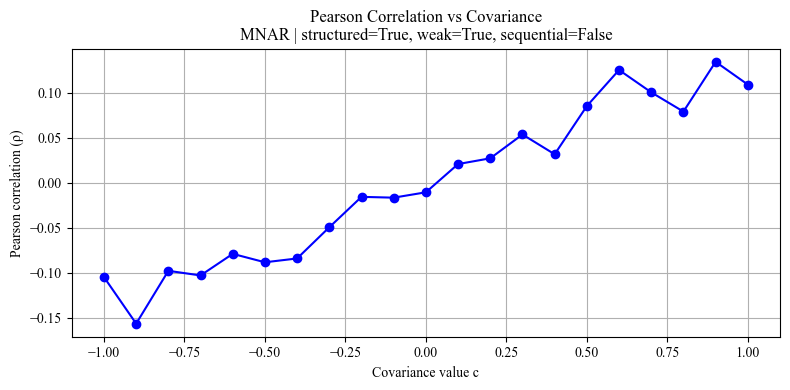

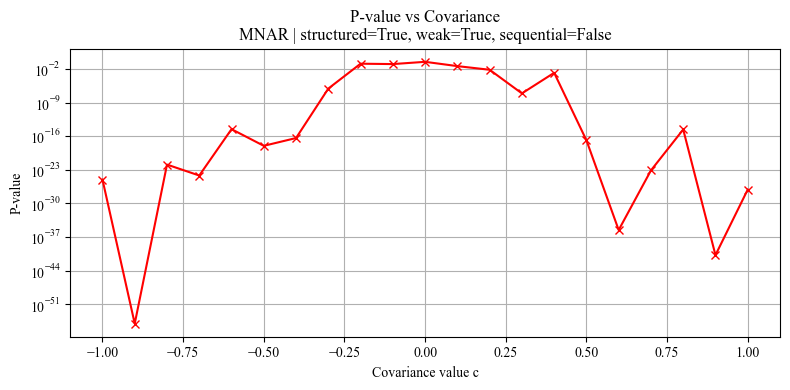

In [701]:
test_cov(mecha="MNAR", structured=True, weak=True, sequential=False)

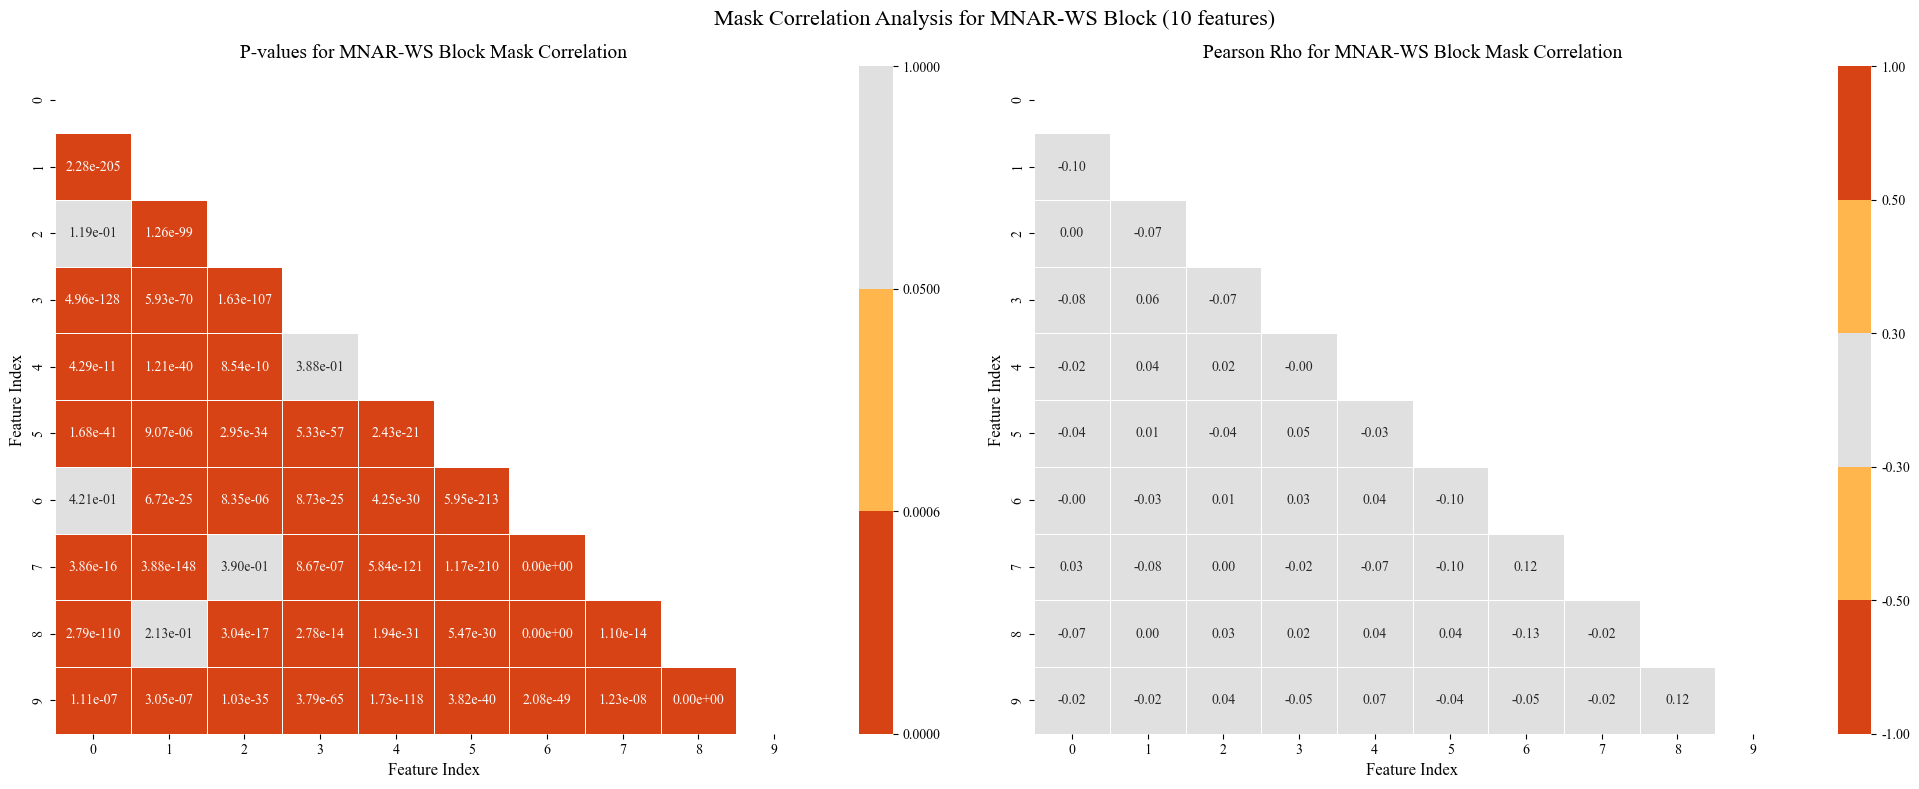

In [702]:
plot_mask_corr(R_mnar_WSB, "MNAR-WS Block")

#### MNAR SS-Block (XV)

Percentage of generated missing values:  40.0  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


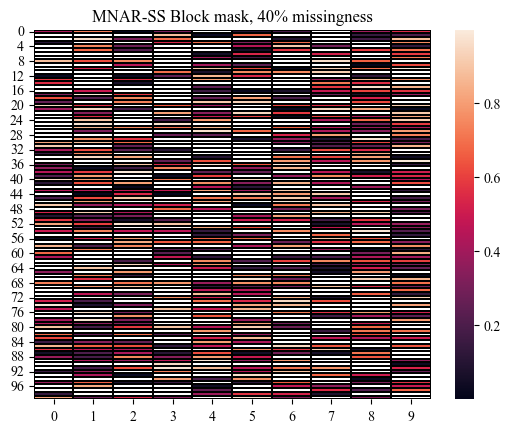

In [703]:
for i in num_tests:
    X_miss_mnar_SSB = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=False, sequential=False)

    X_mnar_SSB = X_miss_mnar_SSB['X_incomp']
    R_mnar_SSB = X_miss_mnar_SSB['mask']

print("Percentage of generated missing values: ", (R_mnar_SSB.sum())/np.prod(R_mnar_SSB.shape)*100, " %")

ax = sns.heatmap(X_mnar_SSB[:100], mask=R_mnar_SSB[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-SS Block"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/simulate.py:318: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  latent_effects = np.random.multivariate_normal(mean, cov, size=n)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


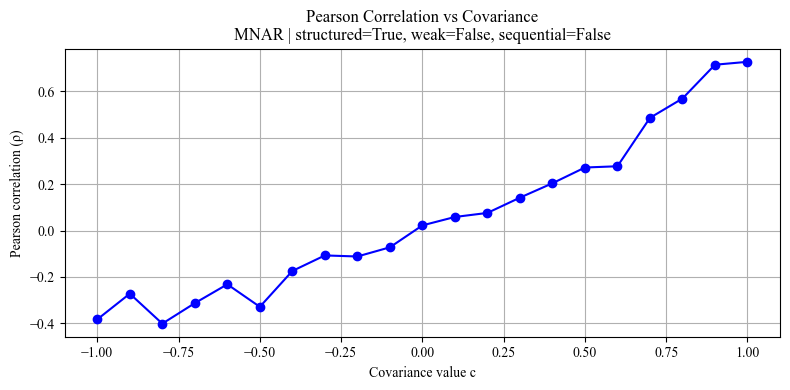

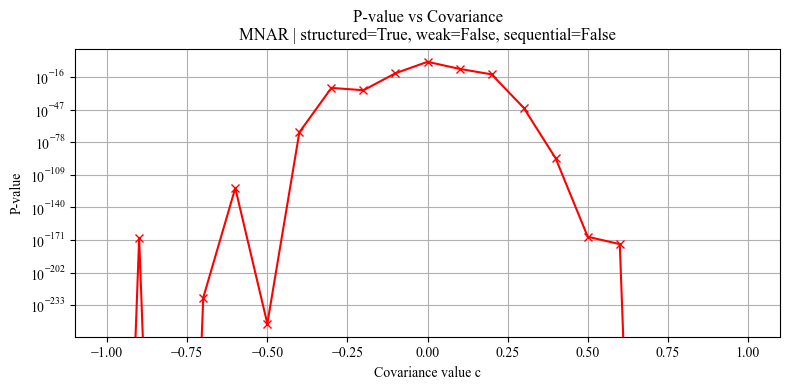

In [704]:
test_cov(mecha="MNAR", structured=True, weak=False, sequential=False)

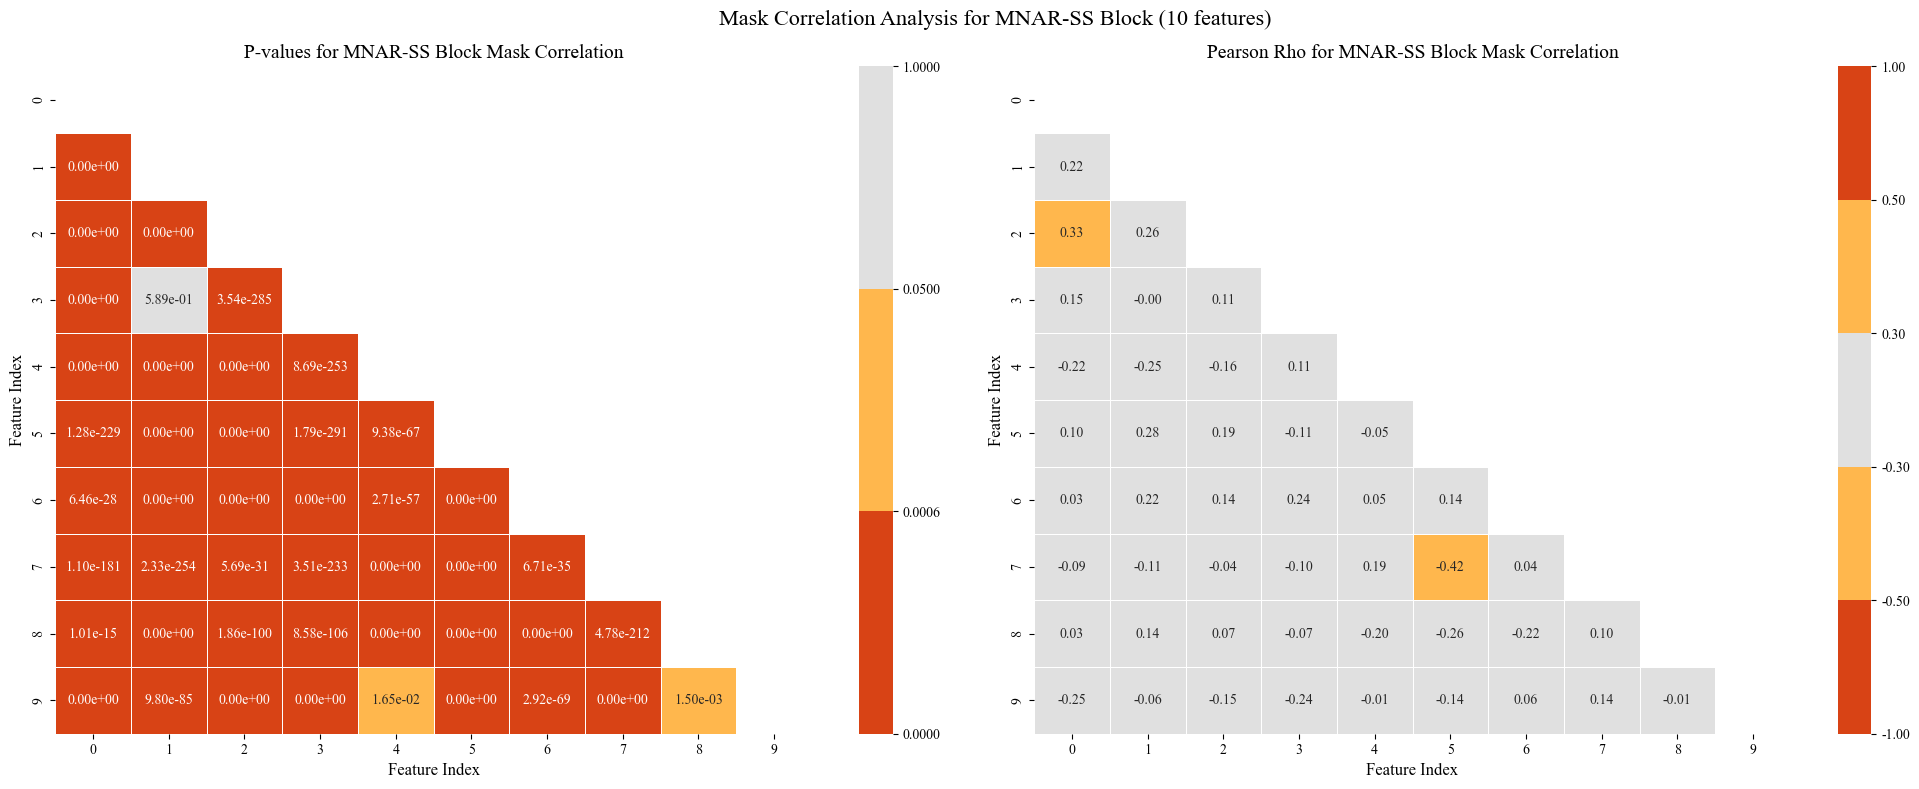

In [705]:
plot_mask_corr(R_mnar_SSB, "MNAR-SS Block")

#### MNAR WS-Sequential (XVI)

/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


Percentage of generated missing values:  40.009299999999996  %


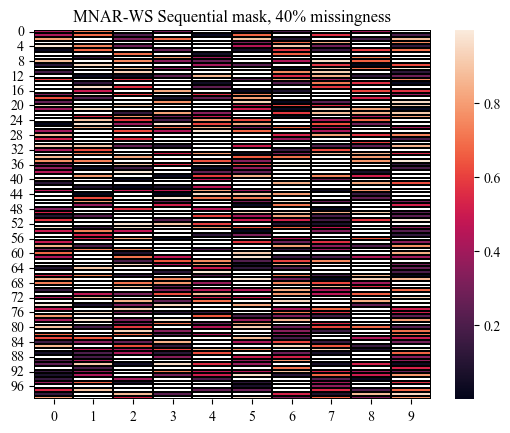

In [706]:
for i in num_tests:
    X_miss_mnar_WSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=True, sequential=True)

    X_mnar_WSS = X_miss_mnar_WSS['X_incomp']
    R_mnar_WSS = X_miss_mnar_WSS['mask']

print("Percentage of generated missing values: ", (R_mnar_WSS.sum())/np.prod(R_mnar_WSS.shape)*100, " %")

ax = sns.heatmap(X_mnar_WSS[:100], mask=R_mnar_WSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-WS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

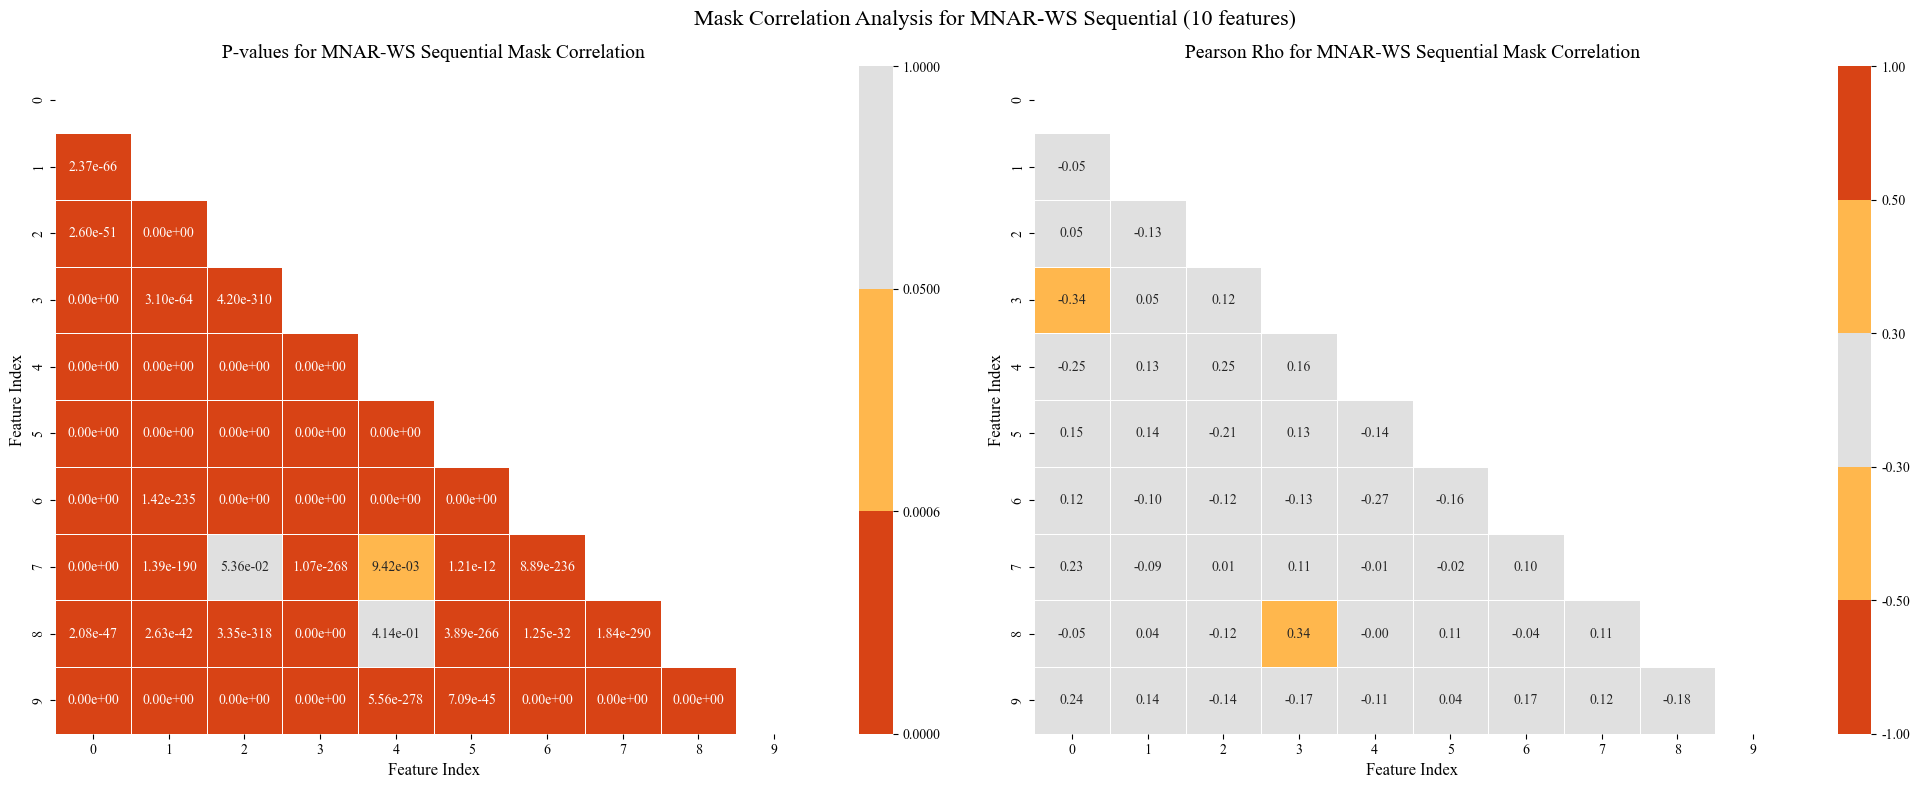

In [707]:
plot_mask_corr(R_mnar_WSS, "MNAR-WS Sequential")

#### MNAR SS-Sequential (XVII)

Percentage of generated missing values:  38.9914  %


/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: divide by zero encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: overflow encountered in matmul
  q, r = divmod(length, num_blocks)
/Users/arvindkalyan/sriram_lab/benchmark/missing_simulation/sim_utils.py:4: RuntimeWarning: invalid value encountered in matmul
  q, r = divmod(length, num_blocks)


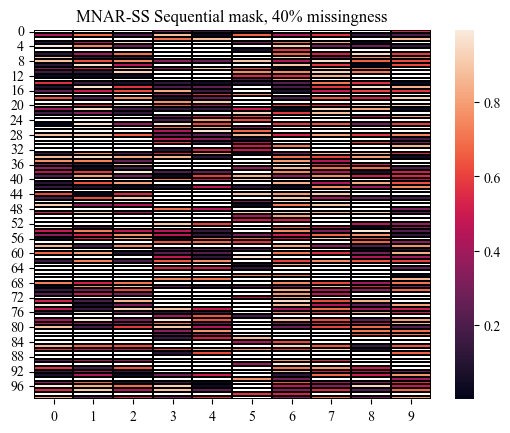

In [708]:
for i in num_tests:
    X_miss_mnar_SSS = simulate_nan(X_complete_cont, p_miss=0.4, mecha="MNAR", p_obs=0.5, structured=True, weak=False, sequential=True)

    X_mnar_SSS = X_miss_mnar_SSS['X_incomp']
    R_mnar_SSS = X_miss_mnar_SSS['mask']

print("Percentage of generated missing values: ", (R_mnar_SSS.sum())/np.prod(R_mnar_SSS.shape)*100, " %")

ax = sns.heatmap(X_mnar_SSS[:100], mask=R_mnar_SSS[:100]==1, linewidths=0.005, linecolor='black')
pattern_name = "MNAR-SS Sequential"
ax.set_title("{} mask, 40% missingness".format(pattern_name))
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
folder_path = "viz/heatmaps/"
file_name = pattern_name.lower().replace(" ", "") + "-hm.png"
full_path = folder_path + file_name
plt.savefig(full_path,dpi=300)
plt.show()

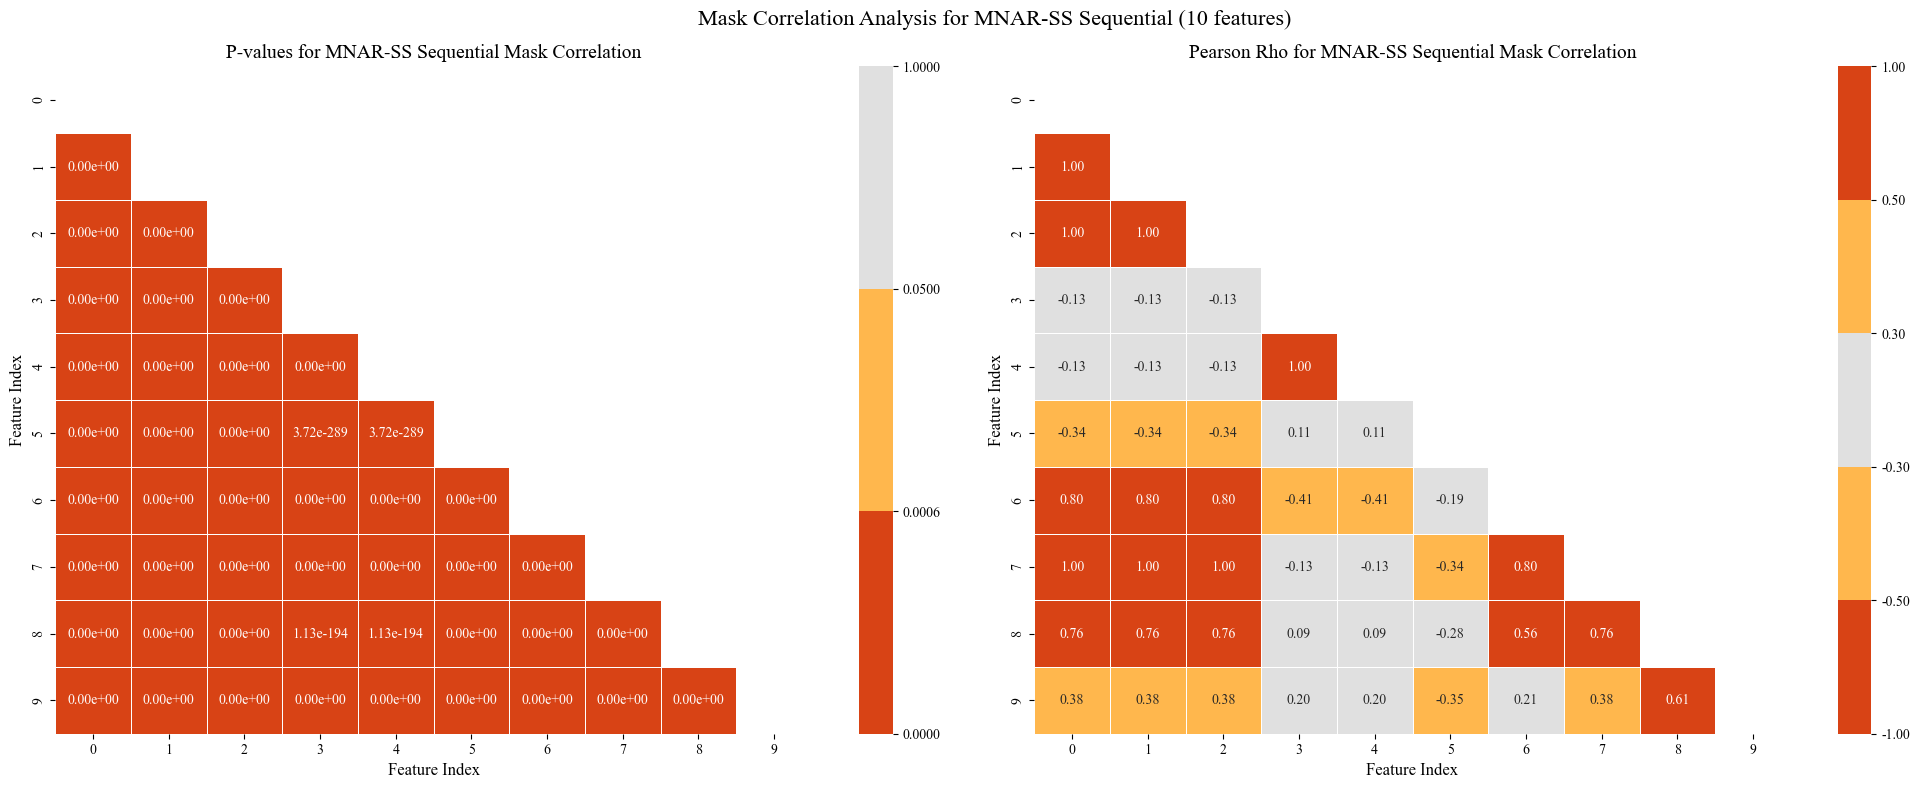

In [709]:
plot_mask_corr(R_mnar_SSS, "MNAR-SS Sequential")